# **Forecasting with Linear Regression**

### **Contents**

- **EDA** - A brief EDA, showing the essentials
- **Imputation** - Realizing that proportion of num_sales is correlated with prorportion of gdp_per_capita. Using this relation to impute missing num_sale values.
- **Model** - Using CatBoost Regressor to fit the dataset.

# **Preliminaries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge

sns.set_style('darkgrid')

In [ ]:
# train_df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv", parse_dates=["date"])
# original_train_df = train_df.copy()
# test_df = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv", parse_dates=["date"])

In [ ]:
train_df = pd.read_csv("train.csv", parse_dates=["date"])
original_train_df = train_df.copy()
test_df = pd.read_csv("test.csv", parse_dates=["date"])

# **EDA**

## **Categorical variables**

In [ ]:
display(train_df.head(3))
display(test_df.head(3))

id       date country              store            product  num_sold
0   0 2010-01-01  Canada  Discount Stickers  Holographic Goose       NaN
1   1 2010-01-01  Canada  Discount Stickers             Kaggle     973.0
2   2 2010-01-01  Canada  Discount Stickers       Kaggle Tiers     906.0

id       date country              store            product
0  230130 2017-01-01  Canada  Discount Stickers  Holographic Goose
1  230131 2017-01-01  Canada  Discount Stickers             Kaggle
2  230132 2017-01-01  Canada  Discount Stickers       Kaggle Tiers

**Observations:**
- There are 3 categorical columns that together describe a univariate time series. Country, Store and Product.

Lets see which countries, stores and products we have data for:

In [ ]:
train_df['country'].value_counts().reset_index().rename(columns={'index':"country", "count":'Value Count'}).set_index('country')

Value Count
country               
Canada           38355
Finland          38355
Italy            38355
Kenya            38355
Norway           38355
Singapore        38355

In [ ]:
train_df['country'].value_counts().reset_index().rename(columns={'country':"Value Count", "index":'country'})#.set_index('country') # previous code that threw the error

# changed code
# train_df['country'].value_counts().reset_index().rename(columns={'index': 'country', 'country': 'Value Count'})#.set_index('country')

Value Count  count
0      Canada  38355
1     Finland  38355
2       Italy  38355
3       Kenya  38355
4      Norway  38355
5   Singapore  38355

In [ ]:
def get_val_counts(df, column_name, sort_by_column_name=False):
    # value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count", "index":column_name}).set_index(column_name)
    value_count = df[column_name].value_counts().reset_index().rename(columns={'index':column_name, "count":'Value Count'}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count

def plot_value_counts_pie(df, column_name, sort_by_column_name=False):
    val_count_df = get_val_counts(df, column_name, sort_by_column_name)
    val_count_df.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel=""); #val_count

def plot_value_counts_bar(df, column_name, sort_by_column_name = False):
    # print(df[column_name])
    val_count_df = get_val_counts(df, column_name, sort_by_column_name)
    # print(val_count_df)
    f,ax = plt.subplots(figsize=(12,6))
    sns.barplot(data = val_count_df, y="Value Count", x=column_name )

    for index, row in val_count_df.iterrows():
        count = row["Value Count"]
        percentage = row["Percentage"]
        ax.text(
            x=index,
            y=row["Value Count"] + max(val_count_df["Value Count"])*0.02,  # Adjust position slightly above the bar
            s=f'{count} ({percentage:.2f}%)',
            ha='center',
            va='bottom'
        )

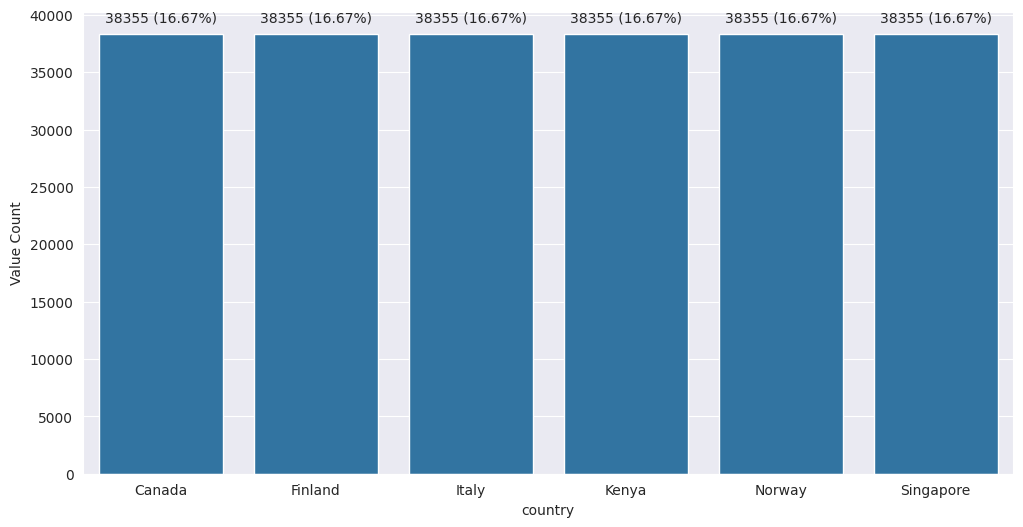

In [ ]:
plot_value_counts_bar(train_df, "country")

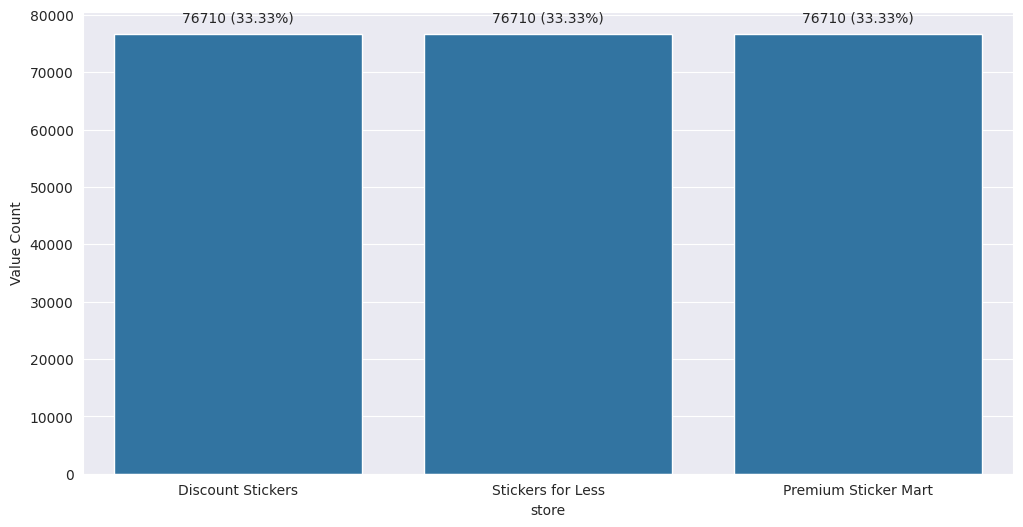

In [ ]:
plot_value_counts_bar(train_df, "store")

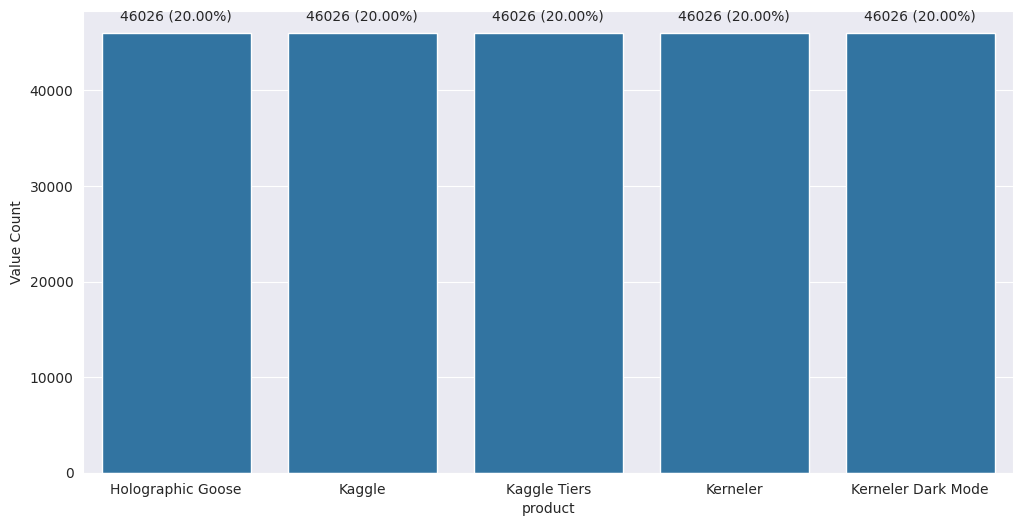

In [ ]:
plot_value_counts_bar(train_df, "product")

**Observations:**
- We have 6 Countries, all occuring in the dataset the same number of time (equal proportions).
- We have 3 Stores, all occuring in the dataset the same number of time (equal proportions)
- We have 5 products, all occuring in the dataset the same number of time (equal proportions)

Look at the number of rows for each country, store and product:

In [ ]:
# counts

In [ ]:
# counts["num_rows"].value_counts()

In [ ]:
counts = train_df.groupby(["country","store","product"])["id"].count().rename("num_rows").reset_index()
counts_val_counts = counts["num_rows"].value_counts().rename("Count").reset_index().rename(columns={"index": "length"})
display(counts_val_counts.head(10))

num_rows  Count
0      2557     90

In total we have **90 univariate time series** all of **length 2557**

However although we have 2557 rows for every single country, product and store, we may have missing values in the number of sales:

In [ ]:
print(f"Number of missing num_sold rows: {train_df['num_sold'].isna().sum()}")

Number of missing num_sold rows: 8871


In [ ]:
# train_df.groupby(["country","store","product"])["num_sold"].count().rename("num_rows")

In [ ]:
counts = train_df.groupby(["country","store","product"])["num_sold"].count().rename("num_rows")
missing_data = counts.loc[counts != 2557]
missing_data_df = missing_data.reset_index()
missing_data_df["num_missing_rows"] = 2557 - missing_data_df["num_rows"]
missing_data_df

country                 store             product  num_rows  \
0  Canada     Discount Stickers   Holographic Goose         0   
1  Canada     Discount Stickers            Kerneler      2556   
2  Canada  Premium Sticker Mart   Holographic Goose      2177   
3  Canada     Stickers for Less   Holographic Goose      1249   
4   Kenya     Discount Stickers   Holographic Goose         0   
5   Kenya     Discount Stickers            Kerneler      2494   
6   Kenya     Discount Stickers  Kerneler Dark Mode      2556   
7   Kenya  Premium Sticker Mart   Holographic Goose      1911   
8   Kenya     Stickers for Less   Holographic Goose      1199   

   num_missing_rows  
0              2557  
1                 1  
2               380  
3              1308  
4              2557  
5                63  
6                 1  
7               646  
8              1358

In [ ]:
# Check to see if the combination of country, store, product, in missing_data_df exists in df_test

# Check if combinations in missing_data_df exist in df_test
def check_combinations(missing_data_df, df_test):
    missing_combinations = set()
    for index, row in missing_data_df.iterrows():
        missing_combinations.add(tuple(row[["country", "store", "product"]].values))
    print(missing_combinations)

    test_combinations = set()
    for index, row in df_test.iterrows():
        test_combinations.add(tuple(row[["country", "store", "product"]].values))
    print(test_combinations)

    common_combinations = missing_combinations.intersection(test_combinations)

    return common_combinations

common_combinations = check_combinations(missing_data_df, test_df)
print(f"Number of Common Combinations: {len(common_combinations)}")

# Print or process common_combinations as needed
# Example:
# print("Common Combinations:", common_combinations)

{('Kenya', 'Stickers for Less', 'Holographic Goose'), ('Kenya', 'Discount Stickers', 'Holographic Goose'), ('Canada', 'Discount Stickers', 'Holographic Goose'), ('Kenya', 'Premium Sticker Mart', 'Holographic Goose'), ('Canada', 'Discount Stickers', 'Kerneler'), ('Kenya', 'Discount Stickers', 'Kerneler'), ('Canada', 'Stickers for Less', 'Holographic Goose'), ('Canada', 'Premium Sticker Mart', 'Holographic Goose'), ('Kenya', 'Discount Stickers', 'Kerneler Dark Mode')}
{('Kenya', 'Premium Sticker Mart', 'Kerneler Dark Mode'), ('Norway', 'Premium Sticker Mart', 'Kerneler Dark Mode'), ('Singapore', 'Discount Stickers', 'Holographic Goose'), ('Canada', 'Discount Stickers', 'Kerneler'), ('Canada', 'Premium Sticker Mart', 'Kerneler Dark Mode'), ('Italy', 'Premium Sticker Mart', 'Holographic Goose'), ('Finland', 'Premium Sticker Mart', 'Kerneler'), ('Italy', 'Stickers for Less', 'Kerneler Dark Mode'), ('Finland', 'Discount Stickers', 'Kaggle'), ('Singapore', 'Discount Stickers', 'Kerneler'), ('

In [ ]:
print("Common Combinations:", common_combinations)

# df_test contains combinations of ["country", "store", "product"] that has missing 'num_sold' in df_train.
# Thus, if we simply drop these out from the training set, we lose valuable information. --> Maybe better to impute missing 'num_sold' value.

Common Combinations: {('Kenya', 'Stickers for Less', 'Holographic Goose'), ('Canada', 'Discount Stickers', 'Holographic Goose'), ('Kenya', 'Discount Stickers', 'Holographic Goose'), ('Kenya', 'Premium Sticker Mart', 'Holographic Goose'), ('Canada', 'Discount Stickers', 'Kerneler'), ('Kenya', 'Discount Stickers', 'Kerneler'), ('Canada', 'Stickers for Less', 'Holographic Goose'), ('Canada', 'Premium Sticker Mart', 'Holographic Goose'), ('Kenya', 'Discount Stickers', 'Kerneler Dark Mode')}


**Observations:**
- In total 9 of the 90 time series (10%) have atleast some missing some data.
- 2 of the time series are completely missing data *Canada, Discount Stickers, Holographic Goose* and *Kenya, Discount Stickers, Holographic Goose*
- 2 of the time series are only missing a single day of data *Canada, Discount Stickers, Kerneler* and *Kenya, Discount Stickers, Kernerler Dark Mode*

Lets take a closer look at when the missing values occur in each of these time series:

In [ ]:
missing_data.index

MultiIndex([('Canada',    'Discount Stickers',  'Holographic Goose'),
            ('Canada',    'Discount Stickers',           'Kerneler'),
            ('Canada', 'Premium Sticker Mart',  'Holographic Goose'),
            ('Canada',    'Stickers for Less',  'Holographic Goose'),
            ( 'Kenya',    'Discount Stickers',  'Holographic Goose'),
            ( 'Kenya',    'Discount Stickers',           'Kerneler'),
            ( 'Kenya',    'Discount Stickers', 'Kerneler Dark Mode'),
            ( 'Kenya', 'Premium Sticker Mart',  'Holographic Goose'),
            ( 'Kenya',    'Stickers for Less',  'Holographic Goose')],
           names=['country', 'store', 'product'])

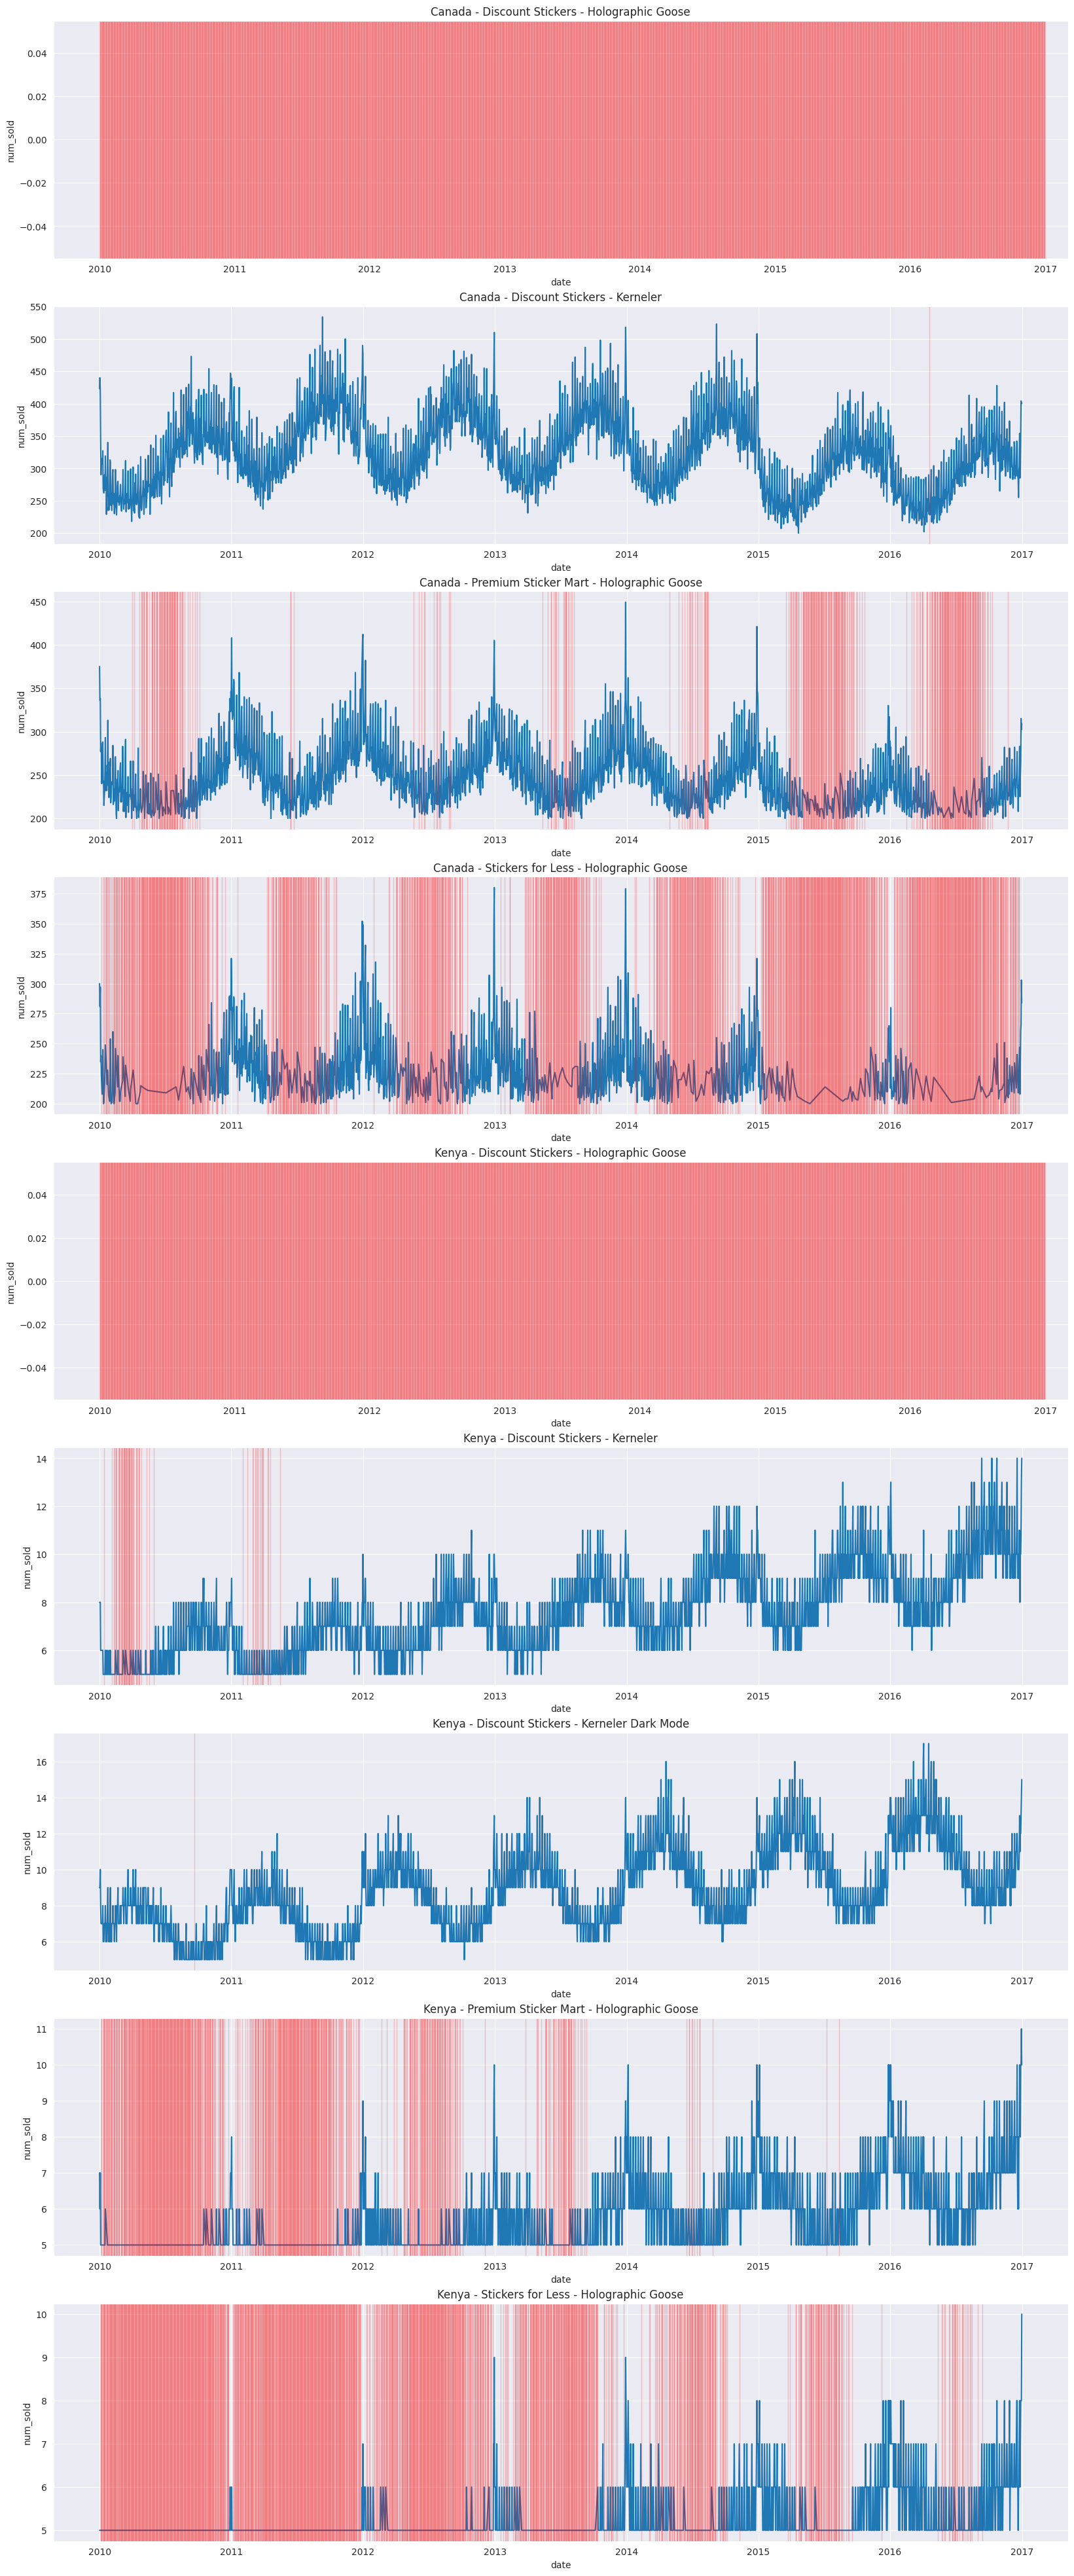

In [ ]:
f,axs = plt.subplots(9,1, figsize=(20,50))
for i, (country, store, product) in enumerate(missing_data.index):
    plot_df = train_df.loc[(train_df["country"] == country) & (train_df["store"] == store) & (train_df["product"] == product)]
    missing_vals = plot_df.loc[plot_df["num_sold"].isna()]
    sns.lineplot(data=plot_df, x="date", y="num_sold", ax=axs[i])
    for missing_date in missing_vals["date"]:
        axs[i].axvline(missing_date, color='red',  linestyle='-', linewidth=1, alpha=0.2)
    axs[i].set_title(f"{country} - {store} - {product}")

**Observations:**
- The missing data is not missing completely randomly (with respect to time), some periods contain more missing data than others.
- It looks data is missing when the value for num_sold < 200 for Canada and < 5 for Kenya (for most the time series). We could impute based on that assumption, but I've used a different method.


## **Time series**

In [ ]:
print("Train - Earliest date:", train_df["date"].min())
print("Train - Latest date:", train_df["date"].max())

print("Test - Earliest date:", test_df["date"].min())
print("Test - Latest date:", test_df["date"].max())

Train - Earliest date: 2010-01-01 00:00:00
Train - Latest date: 2016-12-31 00:00:00
Test - Earliest date: 2017-01-01 00:00:00
Test - Latest date: 2019-12-31 00:00:00


- We have **7 years** of data **from 2010-01-01 to 2016-12-31** to train occuring at **daily frequency**.
- We are required to forecast 3 year of data, **from 2017-01-01 to 2019-12-31**

Lets take a look at the overall trends for each time series:

In [ ]:
# Sum the num_sold across each week, month
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

In [ ]:
weekly_df #sum of all num_sold within a week

country              store             product       date  num_sold
0         Canada  Discount Stickers   Holographic Goose 2010-01-03       0.0
1         Canada  Discount Stickers   Holographic Goose 2010-01-10       0.0
2         Canada  Discount Stickers   Holographic Goose 2010-01-17       0.0
3         Canada  Discount Stickers   Holographic Goose 2010-01-24       0.0
4         Canada  Discount Stickers   Holographic Goose 2010-01-31       0.0
...          ...                ...                 ...        ...       ...
32935  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-04    5630.0
32936  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-11    6106.0
32937  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-18    5942.0
32938  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-25    6307.0
32939  Singapore  Stickers for Less  Kerneler Dark Mode 2017-01-01    6903.0

[32940 rows x 5 columns]

In [ ]:
monthly_df #sum of all num_sold within a month

country              store             product       date  num_sold
0        Canada  Discount Stickers   Holographic Goose 2010-01-01       0.0
1        Canada  Discount Stickers   Holographic Goose 2010-02-01       0.0
2        Canada  Discount Stickers   Holographic Goose 2010-03-01       0.0
3        Canada  Discount Stickers   Holographic Goose 2010-04-01       0.0
4        Canada  Discount Stickers   Holographic Goose 2010-05-01       0.0
...         ...                ...                 ...        ...       ...
7555  Singapore  Stickers for Less  Kerneler Dark Mode 2016-08-01   24317.0
7556  Singapore  Stickers for Less  Kerneler Dark Mode 2016-09-01   22210.0
7557  Singapore  Stickers for Less  Kerneler Dark Mode 2016-10-01   23171.0
7558  Singapore  Stickers for Less  Kerneler Dark Mode 2016-11-01   23750.0
7559  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-01   28636.0

[7560 rows x 5 columns]

In [ ]:
train_df[(train_df['country'] == 'Canada') & (train_df['store'] == 'Discount Stickers') & (train_df['product'] == 'Holographic Goose')]

id       date country              store            product  \
0            0 2010-01-01  Canada  Discount Stickers  Holographic Goose   
90          90 2010-01-02  Canada  Discount Stickers  Holographic Goose   
180        180 2010-01-03  Canada  Discount Stickers  Holographic Goose   
270        270 2010-01-04  Canada  Discount Stickers  Holographic Goose   
360        360 2010-01-05  Canada  Discount Stickers  Holographic Goose   
...        ...        ...     ...                ...                ...   
229680  229680 2016-12-27  Canada  Discount Stickers  Holographic Goose   
229770  229770 2016-12-28  Canada  Discount Stickers  Holographic Goose   
229860  229860 2016-12-29  Canada  Discount Stickers  Holographic Goose   
229950  229950 2016-12-30  Canada  Discount Stickers  Holographic Goose   
230040  230040 2016-12-31  Canada  Discount Stickers  Holographic Goose   

        num_sold  
0            NaN  
90           NaN  
180          NaN  
270          NaN  
360          NaN  
...          ...  
229680       NaN  
229770       NaN  
229860       NaN  
229950       NaN  
230040       NaN  

[2557 rows x 6 columns]

In [ ]:
def plot_all(df):
    f,axes = plt.subplots(3,2,figsize=(25,25), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

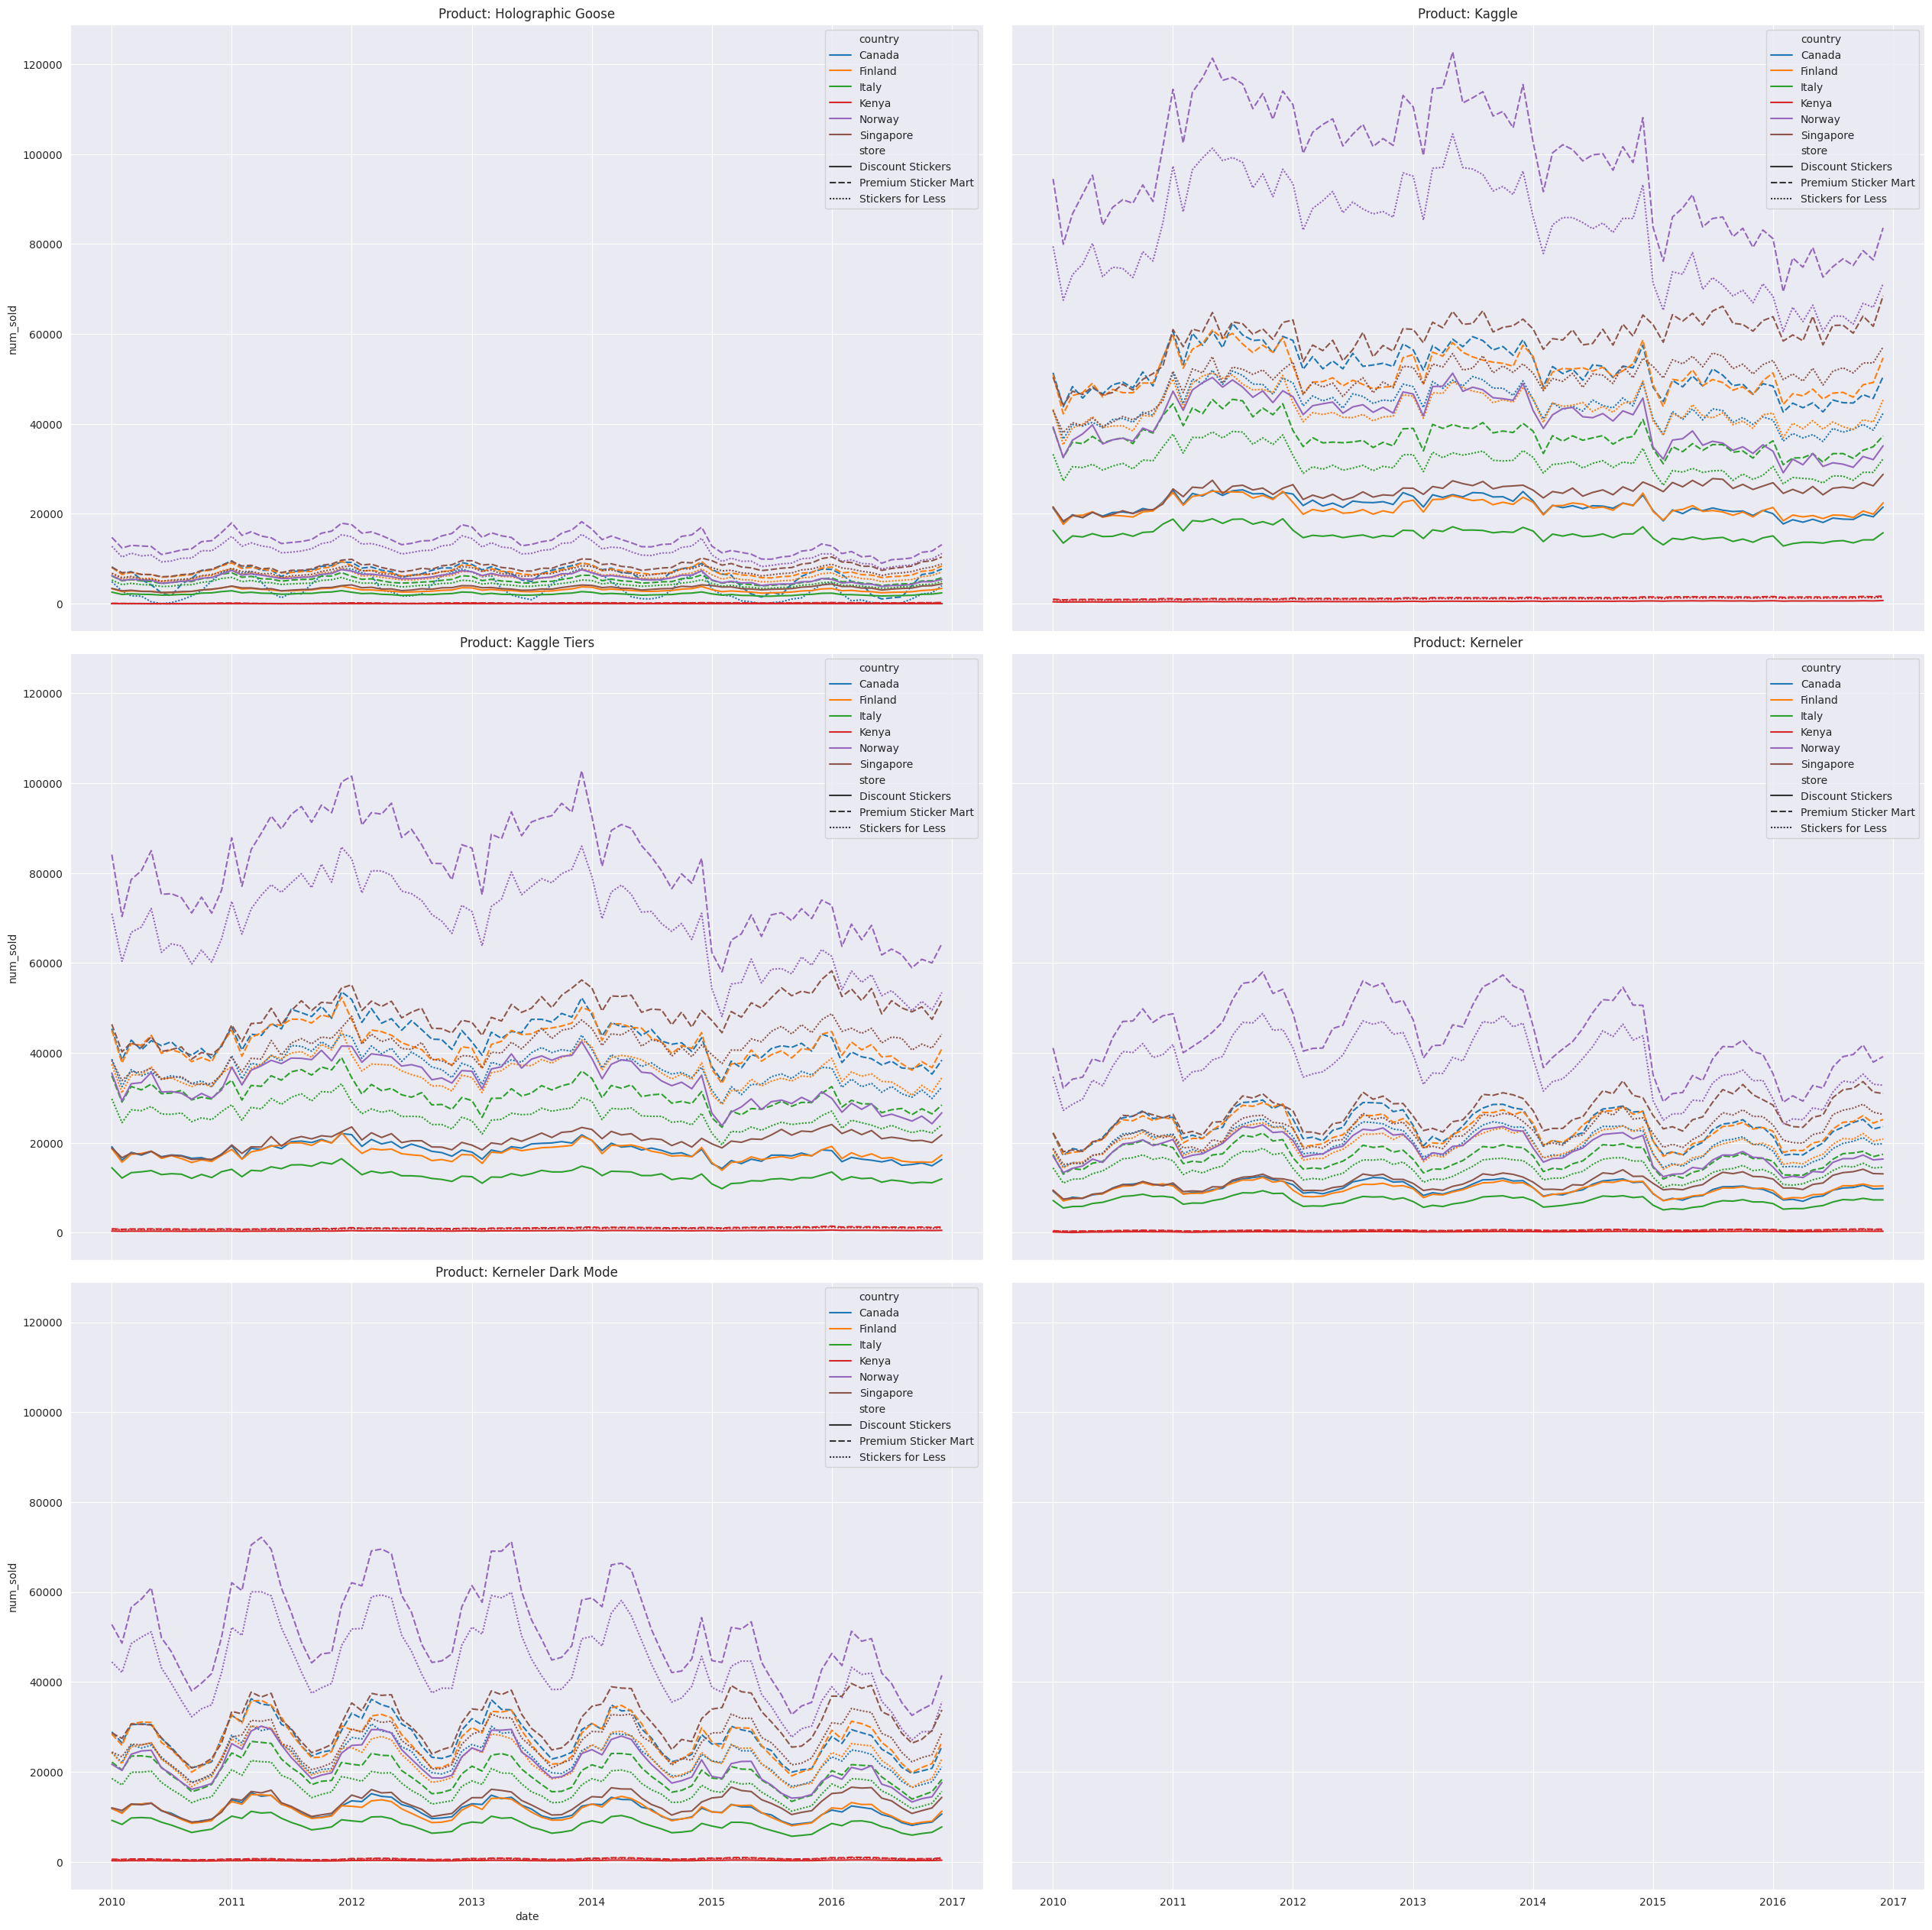

In [ ]:
plot_all(monthly_df)
#plot_all(weekly_df)

# **Aggregating Time Series**

The main theme of this notebook is to show that its a good idea to aggregate the time series across each of the three categorical variables: Store, Country and Product.

## **Country**

First we show that its a good idea to aggregate **countries** when we make the forecast.

To do this we need to show that the proportion of total sales for each country remains constant, regardless of time.

In the graph below, we are looking for straight lines for each country:



In [ ]:
country_weights

country
Canada       0.172087
Finland      0.172362
Italy        0.124908
Kenya        0.004139
Norway       0.327695
Singapore    0.198809
Name: num_sold, dtype: float64

In [ ]:
country_ratio_over_time

date    country  num_sold
0     2010-01-01     Canada  0.176460
1     2010-01-01    Finland  0.179511
2     2010-01-01      Italy  0.136094
3     2010-01-01      Kenya  0.003424
4     2010-01-01     Norway  0.326333
...          ...        ...       ...
15337 2016-12-31    Finland  0.184664
15338 2016-12-31      Italy  0.124894
15339 2016-12-31      Kenya  0.005821
15340 2016-12-31     Norway  0.278390
15341 2016-12-31  Singapore  0.237630

[15342 rows x 3 columns]

In [ ]:
train_df.groupby("country")["num_sold"].sum()

country
Canada       28653095.0
Finland      28698872.0
Italy        20797669.0
Kenya          689141.0
Norway       54562305.0
Singapore    33102374.0
Name: num_sold, dtype: float64

In [ ]:
train_df.groupby(["date","country"])["num_sold"].sum().head(10)

date        country  
2010-01-01  Canada       15099.0
            Finland      15360.0
            Italy        11645.0
            Kenya          293.0
            Norway       27923.0
            Singapore    15246.0
2010-01-02  Canada       14841.0
            Finland      14352.0
            Italy        10888.0
            Kenya          286.0
Name: num_sold, dtype: float64

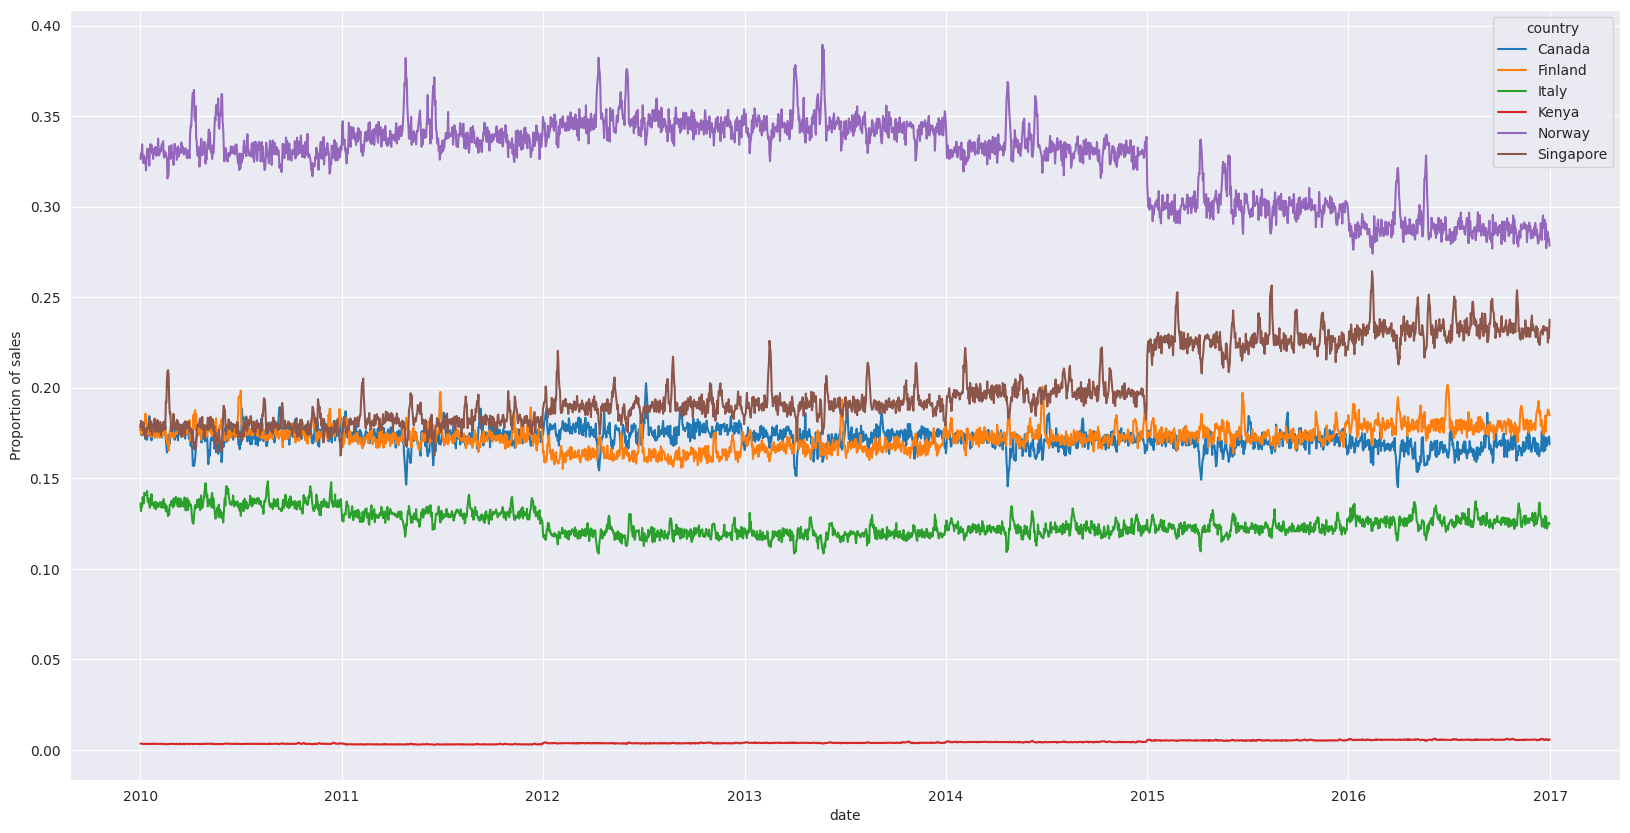

In [ ]:
country_weights = train_df.groupby("country")["num_sold"].sum()/train_df["num_sold"].sum()

country_ratio_over_time = (train_df.groupby(["date","country"])["num_sold"].sum() / train_df.groupby(["date"])["num_sold"].sum()).reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
ax.set_ylabel("Proportion of sales");

**Observations:**
- The lines are **not** perflectly straight, meaning a single constant does not explain the proportion of sales regardless of time.
- The lines for each country do seem to have rises and falls each year (noteably exactly at the year markings) something artificially strange is going on here.

The link seems to be GDP per captia, credit to [@siukeitin](https://www.kaggle.com/siukeitin) for discovering this in this discussion thread https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554349

In [ ]:
# import requests

# def get_gdp_per_capita(alpha3, year):
#     url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json' #https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD
#     response = requests.get(url.format(alpha3,year)).json()
#     return response[1][0]['value']

# alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
# years = range(2010, 2020)
# gdp = pd.DataFrame([
#     [get_gdp_per_capita(alpha3, year) for year in years]
#     for alpha3 in alpha3s
# ], index=np.sort(df_train.country.unique()), columns=years)

# gdp

In [ ]:
import requests

def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

# df = train_df[['date', 'country']].copy()
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
# df['alpha3'] = df['country'].map(dict(zip(
#     np.sort(df['country'].unique()), alpha3s)))
# years = np.sort(df['date'].dt.year.unique())
# df['year'] = df['date'].dt.year

years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp

# gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
# df['GDP'] = df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)

# _, ax = plt.subplots(figsize=(8,10))
# decompose(train, 'country', ax)
# for country in df['country'].unique():
#     mask = df['country']==country
#     ax.plot(df[mask]['date'],df[mask]['GDP'],'k--')
# plt.show()

array([[ 47560.66660094,  52223.85883985,  52670.34473354,
         52638.11872352,  50960.84311747,  43594.19410454,
         42314.06158172,  45129.62811662,  46539.17615704,
         46352.86934452,  43537.8392989 ],
       [ 46506.29190166,  51060.32425898,  47551.67408414,
         49691.01452007,  50073.77608159,  42560.34567671,
         43451.25624422,  46085.0174739 ,  49654.24970353,
         48358.18077737,  48828.68468628],
       [ 36184.71186987,  38851.38813394,  35235.79890582,
         35747.70795269,  35750.71975004,  30387.12931879,
         31126.32469473,  32554.14668453,  34746.34413924,
         33812.78872487,  32091.48666214],
       [  1091.51873101,   1096.14499808,   1285.00536172,
          1370.87885215,   1482.81566253,   1489.11959777,
          1554.12610314,   1667.48447231,   1836.45275529,
          1960.40808855,   1927.66459028],
       [ 88163.20859314, 101221.81347664, 102175.91929837,
        103553.84013442,  97666.69518387,  74809.96580499,
  

In [ ]:
# prompt: gdp as df

gdp_df = pd.DataFrame(gdp, index=np.sort(train_df.country.unique()), columns=years)
gdp_df

2010           2011           2012           2013  \
Canada     47560.666601   52223.858840   52670.344734   52638.118724   
Finland    46506.291902   51060.324259   47551.674084   49691.014520   
Italy      36184.711870   38851.388134   35235.798906   35747.707953   
Kenya       1091.518731    1096.144998    1285.005362    1370.878852   
Norway     88163.208593  101221.813477  102175.919298  103553.840134   
Singapore  47236.683085   53891.457026   55547.555308   56967.425794   

                   2014          2015          2016          2017  \
Canada     50960.843117  43594.194105  42314.061582  45129.628117   
Finland    50073.776082  42560.345677  43451.256244  46085.017474   
Italy      35750.719750  30387.129319  31126.324695  32554.146685   
Kenya       1482.815663   1489.119598   1554.126103   1667.484472   
Norway     97666.695184  74809.965805  70867.360997  76131.838403   
Singapore  57564.802311  55645.606861  56899.918181  61162.097393   

                   2018          2019          2020  
Canada     46539.176157  46352.869345  43537.839299  
Finland    49654.249704  48358.180777  48828.684686  
Italy      34746.344139  33812.788725  32091.486662  
Kenya       1836.452755   1960.408089   1927.664590  
Norway     82792.842711  76430.588947  68340.018103  
Singapore  66840.637339  66081.719924  61466.803676

In [ ]:
# prompt: I want gdp_df to have a column name 'Country Name' with the country entry.

gdp_df = gdp_df.reset_index()
gdp_df = gdp_df.rename(columns={'index': 'Country Name'})
gdp_df

Country Name          2010           2011           2012           2013  \
0       Canada  47560.666601   52223.858840   52670.344734   52638.118724   
1      Finland  46506.291902   51060.324259   47551.674084   49691.014520   
2        Italy  36184.711870   38851.388134   35235.798906   35747.707953   
3        Kenya   1091.518731    1096.144998    1285.005362    1370.878852   
4       Norway  88163.208593  101221.813477  102175.919298  103553.840134   
5    Singapore  47236.683085   53891.457026   55547.555308   56967.425794   

           2014          2015          2016          2017          2018  \
0  50960.843117  43594.194105  42314.061582  45129.628117  46539.176157   
1  50073.776082  42560.345677  43451.256244  46085.017474  49654.249704   
2  35750.719750  30387.129319  31126.324695  32554.146685  34746.344139   
3   1482.815663   1489.119598   1554.126103   1667.484472   1836.452755   
4  97666.695184  74809.965805  70867.360997  76131.838403  82792.842711   
5  57564.802311  55645.606861  56899.918181  61162.097393  66840.637339   

           2019          2020  
0  46352.869345  43537.839299  
1  48358.180777  48828.684686  
2  33812.788725  32091.486662  
3   1960.408089   1927.664590  
4  76430.588947  68340.018103  
5  66081.719924  61466.803676

In [ ]:
gdp_df.columns = gdp_df.columns.astype(str)
gdp_df

Country Name          2010           2011           2012           2013  \
0       Canada  47560.666601   52223.858840   52670.344734   52638.118724   
1      Finland  46506.291902   51060.324259   47551.674084   49691.014520   
2        Italy  36184.711870   38851.388134   35235.798906   35747.707953   
3        Kenya   1091.518731    1096.144998    1285.005362    1370.878852   
4       Norway  88163.208593  101221.813477  102175.919298  103553.840134   
5    Singapore  47236.683085   53891.457026   55547.555308   56967.425794   

           2014          2015          2016          2017          2018  \
0  50960.843117  43594.194105  42314.061582  45129.628117  46539.176157   
1  50073.776082  42560.345677  43451.256244  46085.017474  49654.249704   
2  35750.719750  30387.129319  31126.324695  32554.146685  34746.344139   
3   1482.815663   1489.119598   1554.126103   1667.484472   1836.452755   
4  97666.695184  74809.965805  70867.360997  76131.838403  82792.842711   
5  57564.802311  55645.606861  56899.918181  61162.097393  66840.637339   

           2019          2020  
0  46352.869345  43537.839299  
1  48358.180777  48828.684686  
2  33812.788725  32091.486662  
3   1960.408089   1927.664590  
4  76430.588947  68340.018103  
5  66081.719924  61466.803676

In [ ]:
gdp_df.columns

Index(['Country Name', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020'],
      dtype='object')

In [ ]:
gdp_per_capita_filtered_ratios_df_2

year    country     ratio
0  2010-12-31     Canada  0.178301
1  2010-12-31    Finland  0.174349
2  2010-12-31      Italy  0.135654
3  2010-12-31      Kenya  0.004092
4  2010-12-31     Norway  0.330517
..        ...        ...       ...
61 2020-12-31    Finland  0.190594
62 2020-12-31      Italy  0.125263
63 2020-12-31      Kenya  0.007524
64 2020-12-31     Norway  0.266753
65 2020-12-31  Singapore  0.239924

[66 rows x 3 columns]

In [ ]:
gdp_per_capita_filtered_ratios_df

index       year    country     ratio
0        0 2010-01-01     Canada  0.178301
1        1 2010-01-01    Finland  0.174349
2        2 2010-01-01      Italy  0.135654
3        3 2010-01-01      Kenya  0.004092
4        4 2010-01-01     Norway  0.330517
..     ...        ...        ...       ...
127     61 2020-12-31    Finland  0.190594
128     62 2020-12-31      Italy  0.125263
129     63 2020-12-31      Kenya  0.007524
130     64 2020-12-31     Norway  0.266753
131     65 2020-12-31  Singapore  0.239924

[132 rows x 4 columns]

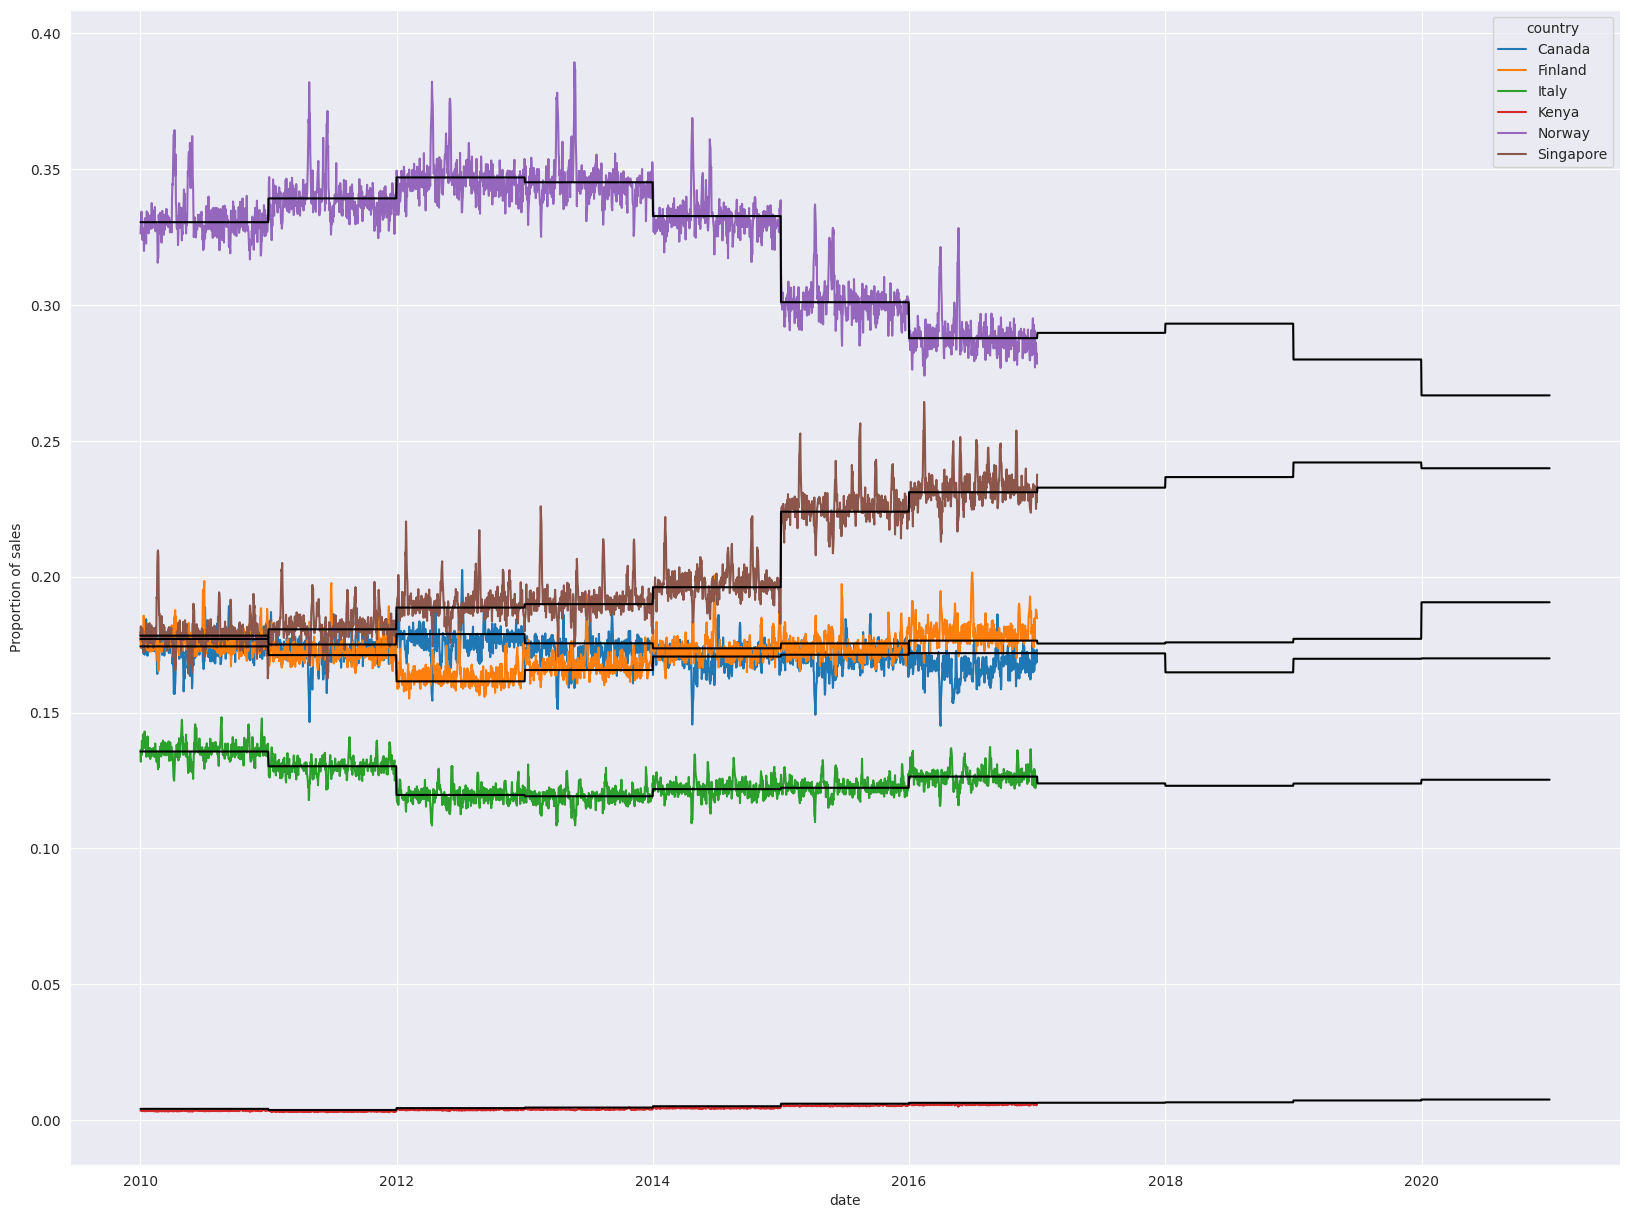

In [ ]:
# gdp_per_capita_df = pd.read_csv("/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_per_capita.csv")
gdp_per_capita_df = gdp_df

years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')

# For plotting purposes
gdp_per_capita_filtered_ratios_df_2 = gdp_per_capita_filtered_ratios_df.copy()
gdp_per_capita_filtered_ratios_df_2["year"] = pd.to_datetime(gdp_per_capita_filtered_ratios_df_2['year'].astype(str)) + pd.offsets.YearEnd(1)
gdp_per_capita_filtered_ratios_df = pd.concat([gdp_per_capita_filtered_ratios_df, gdp_per_capita_filtered_ratios_df_2]).reset_index()

f,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
sns.lineplot(data = gdp_per_capita_filtered_ratios_df, x="year", y = "ratio", hue="country", palette = ["black"]*6, legend = False)
ax.set_ylabel("Proportion of sales");

**Observations:**
- The black line shows the ratio of GDP per captia for each year for that country compared to the sum of GDP per capita for all the other countries.
- Note that Canada and Kenya do not perfectly allign to these ratios, likely because of missing values, this is fine.
- There might be some slight non-random noise here, so perhaps this method isn't quite perfect?

**Insight:**
- This means we can predict the proportion of sales between each country for each year that we have to forecast for, by considering the annual GDP per capita. This means we can aggregate the number of sales across countries for each product and store when making the forecast and then disagregate using the known annual GDP per capita ratios for the years we are predicting for. To prove this we can see if the lines for countries overlap with each other when applying our ratios of GDP per captia for each country and year.

In [ ]:
gdp_per_capita_filtered_ratios_df_2

year    country     ratio
0  2010-12-31     Canada  0.178301
1  2010-12-31    Finland  0.174349
2  2010-12-31      Italy  0.135654
3  2010-12-31      Kenya  0.004092
4  2010-12-31     Norway  0.330517
..        ...        ...       ...
61 2020-12-31    Finland  0.190594
62 2020-12-31      Italy  0.125263
63 2020-12-31      Kenya  0.007524
64 2020-12-31     Norway  0.266753
65 2020-12-31  Singapore  0.239924

[66 rows x 3 columns]

In [ ]:
gdp_per_capita_filtered_ratios_df_2

year    country     ratio
0  2010-12-31     Canada  0.178301
1  2010-12-31    Finland  0.174349
2  2010-12-31      Italy  0.135654
3  2010-12-31      Kenya  0.004092
4  2010-12-31     Norway  0.330517
..        ...        ...       ...
61 2020-12-31    Finland  0.190594
62 2020-12-31      Italy  0.125263
63 2020-12-31      Kenya  0.007524
64 2020-12-31     Norway  0.266753
65 2020-12-31  Singapore  0.239924

[66 rows x 3 columns]

In [ ]:
gdp_per_capita_filtered_ratios_df_2["year"] = gdp_per_capita_filtered_ratios_df_2["year"].dt.year

def plot_adjust_country(df):
    new_df = df.copy()
    new_df["year"] = new_df["date"].dt.year

    for country in new_df["country"].unique():
        for year in new_df["year"].unique():
            new_df.loc[(new_df["country"] == country) & (new_df["year"] == year), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["year"] == year), "num_sold"] / gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["country"] == country) & (gdp_per_capita_filtered_ratios_df_2["year"] == year), "ratio"].values[0]

    print(new_df) #
    plot_all(new_df)

# If the lines for countries overlap each other, this means that the our assumption of: (num_sold[year]) / (num_sold[year].sum()) ~= (gdp_per_capita[year]) / (gdp_per_capita[year].sum())
# is quite accurate.
# What we are plotting is: num_sold[year].sum() = (num_sold[year]) / (gdp_per_capita[year] / gdp_per_capita[year].sum())


In [ ]:
monthly_df

country              store             product       date  num_sold
0        Canada  Discount Stickers   Holographic Goose 2010-01-01       0.0
1        Canada  Discount Stickers   Holographic Goose 2010-02-01       0.0
2        Canada  Discount Stickers   Holographic Goose 2010-03-01       0.0
3        Canada  Discount Stickers   Holographic Goose 2010-04-01       0.0
4        Canada  Discount Stickers   Holographic Goose 2010-05-01       0.0
...         ...                ...                 ...        ...       ...
7555  Singapore  Stickers for Less  Kerneler Dark Mode 2016-08-01   24317.0
7556  Singapore  Stickers for Less  Kerneler Dark Mode 2016-09-01   22210.0
7557  Singapore  Stickers for Less  Kerneler Dark Mode 2016-10-01   23171.0
7558  Singapore  Stickers for Less  Kerneler Dark Mode 2016-11-01   23750.0
7559  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-01   28636.0

[7560 rows x 5 columns]

        country              store             product       date  \
0        Canada  Discount Stickers   Holographic Goose 2010-01-01   
1        Canada  Discount Stickers   Holographic Goose 2010-02-01   
2        Canada  Discount Stickers   Holographic Goose 2010-03-01   
3        Canada  Discount Stickers   Holographic Goose 2010-04-01   
4        Canada  Discount Stickers   Holographic Goose 2010-05-01   
...         ...                ...                 ...        ...   
7555  Singapore  Stickers for Less  Kerneler Dark Mode 2016-08-01   
7556  Singapore  Stickers for Less  Kerneler Dark Mode 2016-09-01   
7557  Singapore  Stickers for Less  Kerneler Dark Mode 2016-10-01   
7558  Singapore  Stickers for Less  Kerneler Dark Mode 2016-11-01   
7559  Singapore  Stickers for Less  Kerneler Dark Mode 2016-12-01   

           num_sold  year  
0          0.000000  2010  
1          0.000000  2010  
2          0.000000  2010  
3          0.000000  2010  
4          0.000000  2010  
...

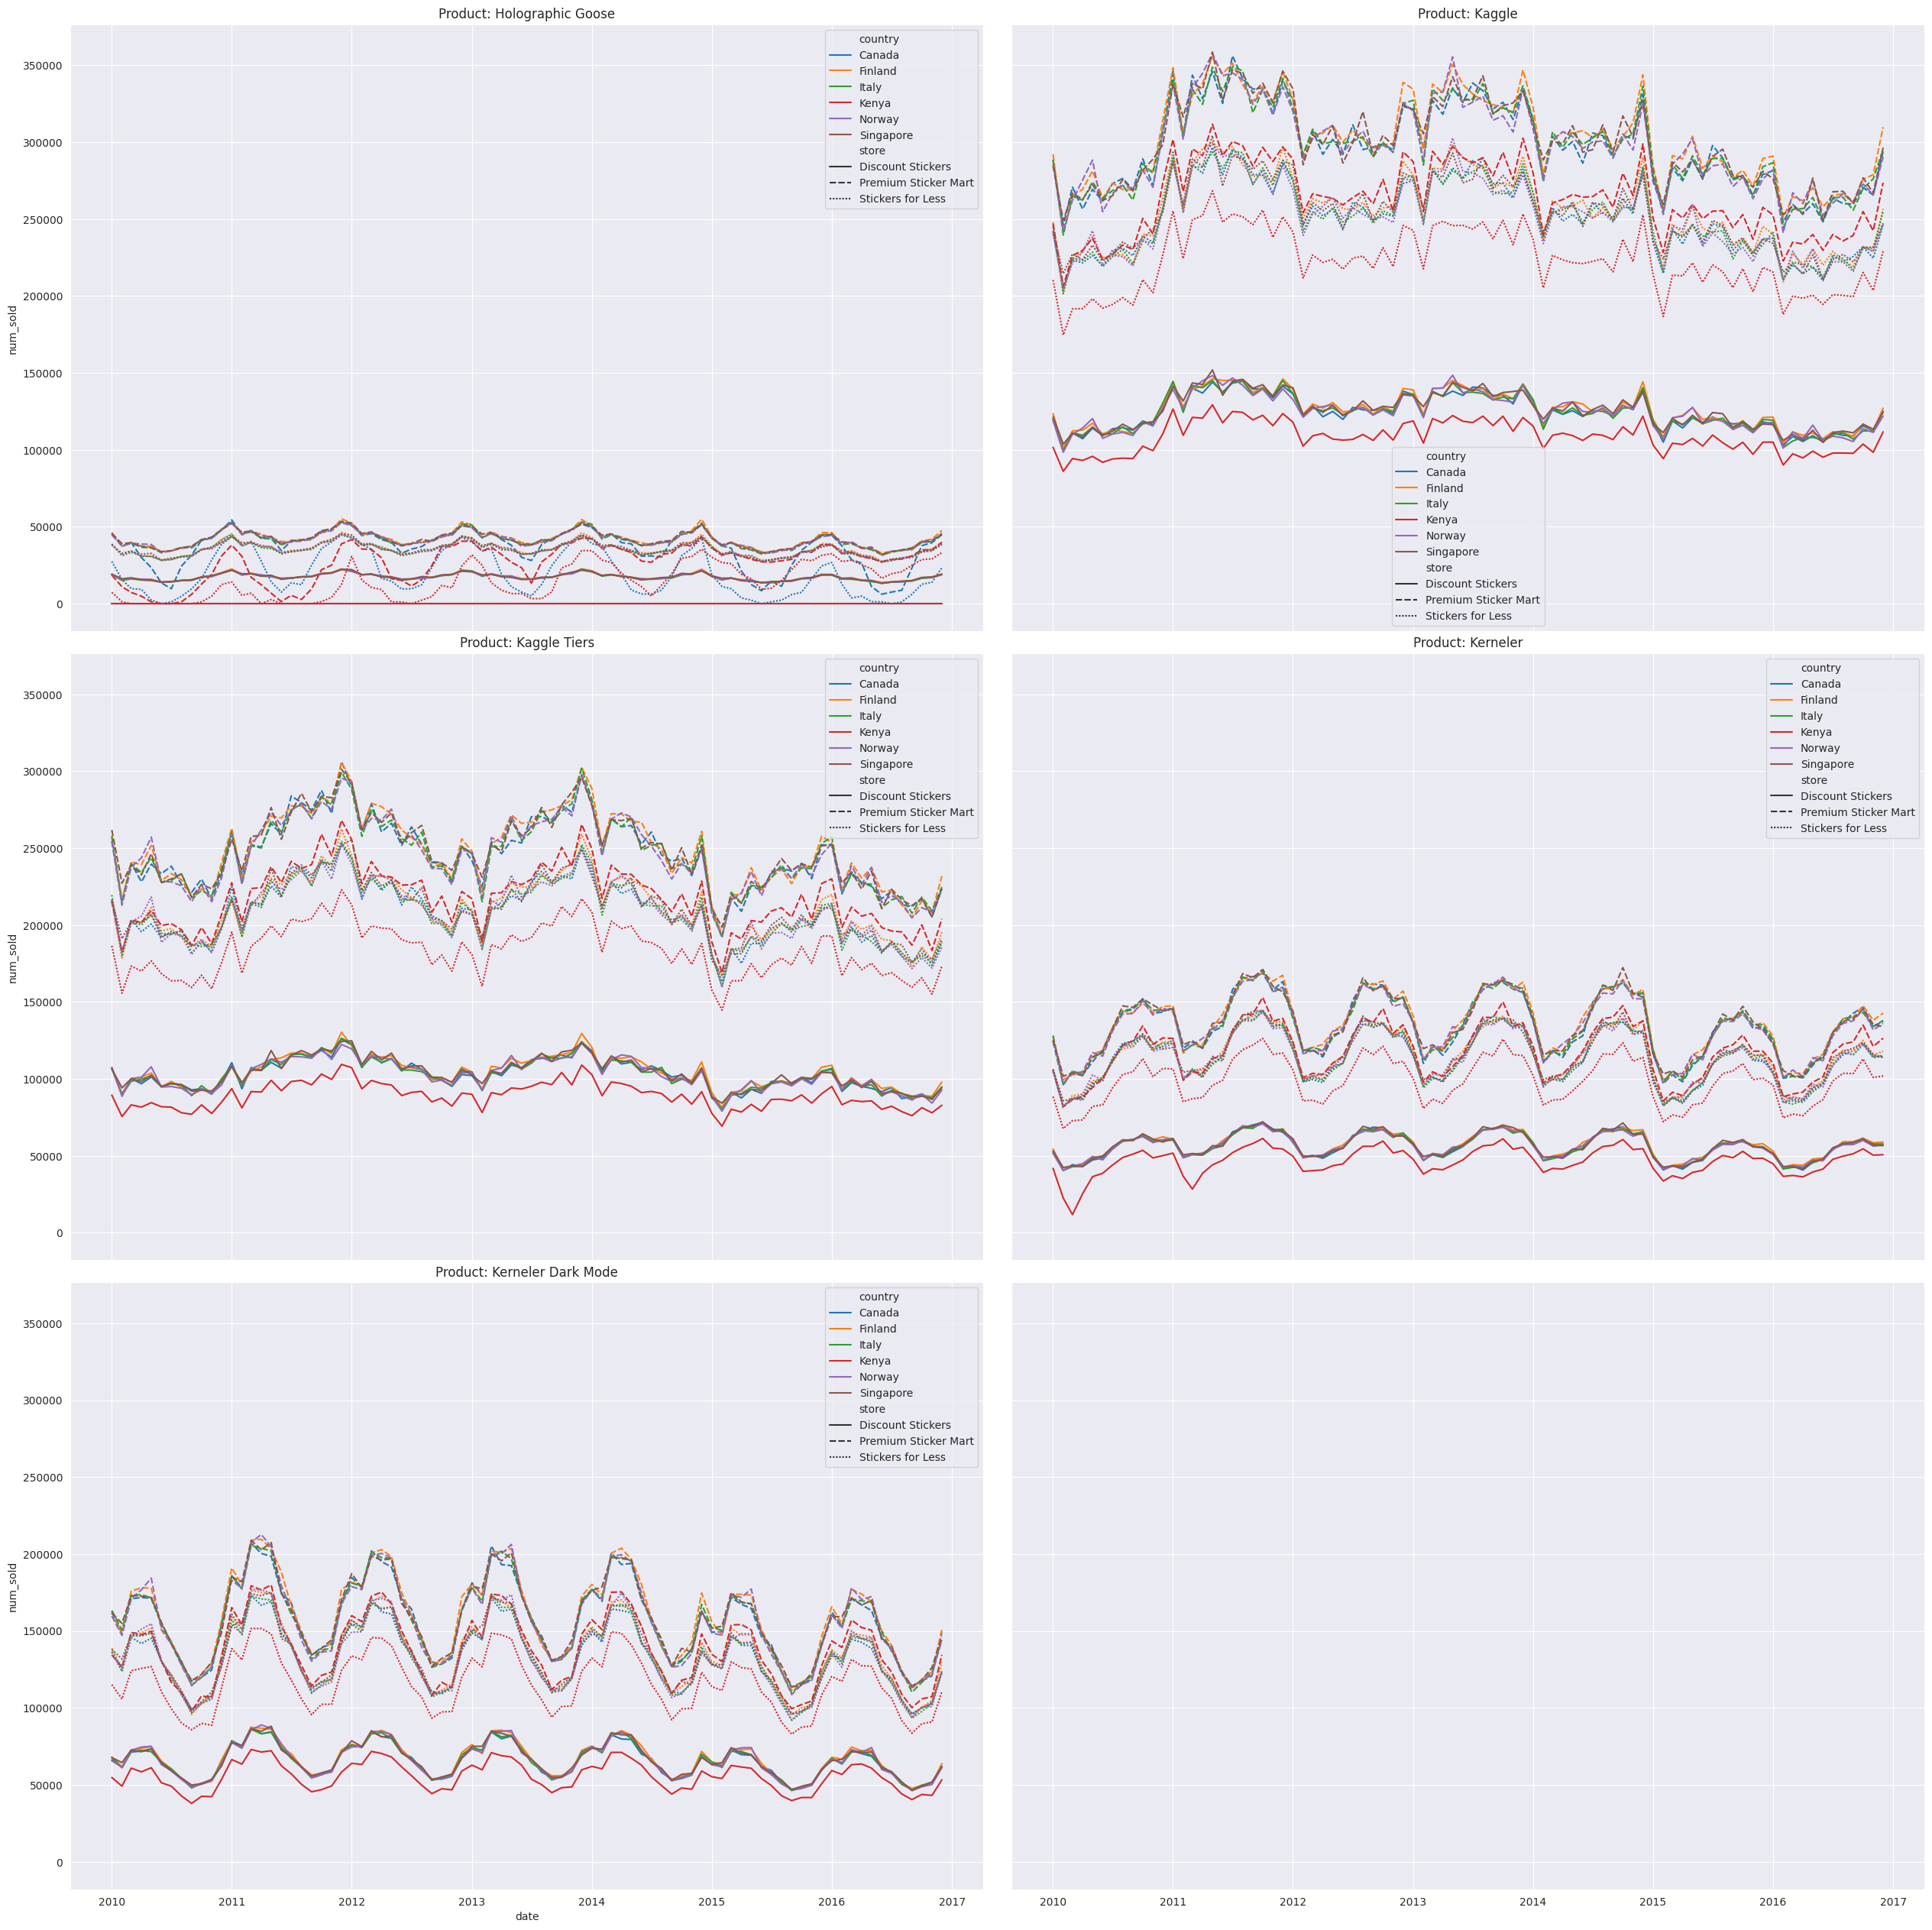

In [ ]:
plot_adjust_country(monthly_df)

**Observations:**

- With the exception of Kenya (probably as the number of sales from Kenya are very low e.g. 5 sales a day and times by a very large constant) and sometimes Canada (because of the missing values) the number of sales overlap well for each store and product!

**Insights:**
- We can aggregate Countries when making the forecast and then disagregate the forecast by using the known ratios of GDP per capita for each year for each country.
- We can use this information for imputation of the missing values (including the completely missing time series) by looking at sales from the same product and some store but for differnt countries, and applying the ratios to guess what the missing values would have been.

### Imputing missing target values 'num_sold'

In [ ]:
train_df_imputed = train_df.copy()
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

train_df_imputed["year"] = train_df_imputed["date"].dt.year
for year in train_df_imputed["year"].unique():
    # Impute Time Series 1 (Canada, Discount Stickers, Holographic Goose)
    target_ratio = gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["year"] == year) & (gdp_per_capita_filtered_ratios_df_2["country"] == "Norway"), "ratio"].values[0] # Using Norway as should have the best precision
    current_raito = gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["year"] == year) & (gdp_per_capita_filtered_ratios_df_2["country"] == "Canada"), "ratio"].values[0]
    ratio_can = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] * ratio_can).values

    # Impute Time Series 2 (Only Missing Values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values

    # Impute Time Series 3 (Only Missing Values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values

    # Impute Time Series 4 (Kenya, Discount Stickers, Holographic Goose)
    current_raito = gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["year"] == year) & (gdp_per_capita_filtered_ratios_df_2["country"] == "Kenya"), "ratio"].values[0]
    ratio_ken = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose")& (train_df_imputed["year"] == year), "num_sold"] * ratio_ken).values

    # Impute Time Series 5 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    # Impute Time Series 6 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    # Impute Time Series 7 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

# num_sold[year] of country_A = num_sold[year] of country_reference * ((gdp_per_capita[year] of country_A / gdp_per_capita[year].sum()) / (gdp_per_capita[year] of country_reference / gdp_per_capita[year].sum()))


Missing values remaining: 8871
Missing values remaining: 2


It seems a bit overkill to replace the entire timeseries for the remaining 2 missing values, I'll just fill them in manually using the graphs from earlier:

In [ ]:
missing_rows = train_df_imputed.loc[train_df_imputed["num_sold"].isna()]
display(missing_rows)
train_df_imputed.loc[train_df_imputed["id"] == 23719, "num_sold"] = 4
train_df_imputed.loc[train_df_imputed["id"] == 207003, "num_sold"] = 195

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

id       date country              store             product  \
23719    23719 2010-09-21   Kenya  Discount Stickers  Kerneler Dark Mode   
207003  207003 2016-04-19  Canada  Discount Stickers            Kerneler   

        num_sold  year  
23719        NaN  2010  
207003       NaN  2016

Missing values remaining: 0


In [ ]:
train_df_imputed.isna().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
year        0
dtype: int64

In [ ]:
train_df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        230130 non-null  int64         
 1   date      230130 non-null  datetime64[ns]
 2   country   230130 non-null  object        
 3   store     230130 non-null  object        
 4   product   230130 non-null  object        
 5   num_sold  230130 non-null  float64       
 6   year      230130 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 11.4+ MB


# Feature Engineer
- Date features
- Holiday
- gdp_per_capita

In [ ]:
train_df_imputed

id       date    country                 store  \
0            0 2010-01-01     Canada     Discount Stickers   
1            1 2010-01-01     Canada     Discount Stickers   
2            2 2010-01-01     Canada     Discount Stickers   
3            3 2010-01-01     Canada     Discount Stickers   
4            4 2010-01-01     Canada     Discount Stickers   
...        ...        ...        ...                   ...   
230125  230125 2016-12-31  Singapore  Premium Sticker Mart   
230126  230126 2016-12-31  Singapore  Premium Sticker Mart   
230127  230127 2016-12-31  Singapore  Premium Sticker Mart   
230128  230128 2016-12-31  Singapore  Premium Sticker Mart   
230129  230129 2016-12-31  Singapore  Premium Sticker Mart   

                   product     num_sold  year  
0        Holographic Goose   140.799481  2010  
1                   Kaggle   973.000000  2010  
2             Kaggle Tiers   906.000000  2010  
3                 Kerneler   423.000000  2010  
4       Kerneler Dark Mode   491.000000  2010  
...                    ...          ...   ...  
230125   Holographic Goose   466.000000  2016  
230126              Kaggle  2907.000000  2016  
230127        Kaggle Tiers  2299.000000  2016  
230128            Kerneler  1242.000000  2016  
230129  Kerneler Dark Mode  1622.000000  2016  

[230130 rows x 7 columns]

In [ ]:
test_df

id       date    country                 store             product
0      230130 2017-01-01     Canada     Discount Stickers   Holographic Goose
1      230131 2017-01-01     Canada     Discount Stickers              Kaggle
2      230132 2017-01-01     Canada     Discount Stickers        Kaggle Tiers
3      230133 2017-01-01     Canada     Discount Stickers            Kerneler
4      230134 2017-01-01     Canada     Discount Stickers  Kerneler Dark Mode
...       ...        ...        ...                   ...                 ...
98545  328675 2019-12-31  Singapore  Premium Sticker Mart   Holographic Goose
98546  328676 2019-12-31  Singapore  Premium Sticker Mart              Kaggle
98547  328677 2019-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers
98548  328678 2019-12-31  Singapore  Premium Sticker Mart            Kerneler
98549  328679 2019-12-31  Singapore  Premium Sticker Mart  Kerneler Dark Mode

[98550 rows x 5 columns]

In [ ]:
def feature_engineer(df):
    # Date
    new_df = df.copy()
    new_df["year"] = new_df["date"].dt.year
    new_df["month"] = new_df["date"].dt.month
    new_df["day_of_month"] = new_df["date"].dt.day
    new_df["day_of_week"] = new_df["date"].dt.dayofweek
    new_df["day_of_year"] = new_df["date"].dt.dayofyear
    new_df["week_of_year"] = new_df["date"].dt.isocalendar().week

    new_df['day_sin'] = np.sin(new_df['day_of_month'] * (2 * np.pi / 31))
    new_df['day_cos'] = np.cos(new_df['day_of_month'] * (2 * np.pi / 31))
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi / 12))

    return new_df

train_df_new = feature_engineer(train_df_imputed)
test_df_new = feature_engineer(test_df)

In [ ]:
train_df_new.shape

(230130, 16)

In [ ]:
test_df_new.shape

(98550, 15)

In [ ]:
pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.4 MB/s eta 0:00:00


In [ ]:
# Holiday

import pycountry
import holidays
import pandas as pd


def get_country_code(country_name):
    try:
        # Find the country object using pycountry based on the country name
        country_obj = pycountry.countries.get(name=country_name)
        country_code = country_obj.alpha_2  # Get the alpha_2 code from the country object
        return country_code

    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None


def get_row_holiday(row):
    country_code = get_country_code(row['country'])

    if country_code is None:
        return 'Unknown Country'

    try:
        # Convert the date string back to a datetime object
        date_obj = pd.to_datetime(row['date'])
        country_holiday_dict = holidays.CountryHoliday(country_code, years=date_obj.year)
        return country_holiday_dict.get(date_obj)

    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'


train_df_new['holidays'] = train_df_new.apply(get_row_holiday, axis=1)
test_df_new['holidays'] = test_df_new.apply(get_row_holiday, axis=1)

# 8m 41s

In [ ]:
train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            230130 non-null  int64         
 1   date          230130 non-null  datetime64[ns]
 2   country       230130 non-null  object        
 3   store         230130 non-null  object        
 4   product       230130 non-null  object        
 5   num_sold      230130 non-null  float64       
 6   year          230130 non-null  int32         
 7   month         230130 non-null  int32         
 8   day_of_month  230130 non-null  int32         
 9   day_of_week   230130 non-null  int32         
 10  day_of_year   230130 non-null  int32         
 11  week_of_year  230130 non-null  UInt32        
 12  day_sin       230130 non-null  float64       
 13  day_cos       230130 non-null  float64       
 14  month_sin     230130 non-null  float64       
 15  month_cos     230

In [ ]:
test_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            98550 non-null  int64         
 1   date          98550 non-null  datetime64[ns]
 2   country       98550 non-null  object        
 3   store         98550 non-null  object        
 4   product       98550 non-null  object        
 5   year          98550 non-null  int32         
 6   month         98550 non-null  int32         
 7   day_of_month  98550 non-null  int32         
 8   day_of_week   98550 non-null  int32         
 9   day_of_year   98550 non-null  int32         
 10  week_of_year  98550 non-null  UInt32        
 11  day_sin       98550 non-null  float64       
 12  day_cos       98550 non-null  float64       
 13  month_sin     98550 non-null  float64       
 14  month_cos     98550 non-null  float64       
 15  holidays      3045 non-null   object

In [ ]:
# Set 'Country Name' as index
gdp_df_new = gdp_df.set_index('Country Name', inplace=False)
gdp_df_new

# Remove any leading or trailing whitespace
gdp_df_new.index = gdp_df_new.index.str.strip()
train_df_new['country'] = train_df_new['country'].str.strip()
test_df_new['country'] = test_df_new['country'].str.strip()

In [ ]:
train_df_new['gdp'] = train_df_new.apply(
    lambda s: gdp_df_new.loc[s['country'], str(s['year'])], axis=1
)

test_df_new['gdp'] = test_df_new.apply(
    lambda s: gdp_df_new.loc[s['country'], str(s['year'])], axis=1
)
train_df_new

id       date    country                 store  \
0            0 2010-01-01     Canada     Discount Stickers   
1            1 2010-01-01     Canada     Discount Stickers   
2            2 2010-01-01     Canada     Discount Stickers   
3            3 2010-01-01     Canada     Discount Stickers   
4            4 2010-01-01     Canada     Discount Stickers   
...        ...        ...        ...                   ...   
230125  230125 2016-12-31  Singapore  Premium Sticker Mart   
230126  230126 2016-12-31  Singapore  Premium Sticker Mart   
230127  230127 2016-12-31  Singapore  Premium Sticker Mart   
230128  230128 2016-12-31  Singapore  Premium Sticker Mart   
230129  230129 2016-12-31  Singapore  Premium Sticker Mart   

                   product     num_sold  year  month  day_of_month  \
0        Holographic Goose   140.799481  2010      1             1   
1                   Kaggle   973.000000  2010      1             1   
2             Kaggle Tiers   906.000000  2010      1             1   
3                 Kerneler   423.000000  2010      1             1   
4       Kerneler Dark Mode   491.000000  2010      1             1   
...                    ...          ...   ...    ...           ...   
230125   Holographic Goose   466.000000  2016     12            31   
230126              Kaggle  2907.000000  2016     12            31   
230127        Kaggle Tiers  2299.000000  2016     12            31   
230128            Kerneler  1242.000000  2016     12            31   
230129  Kerneler Dark Mode  1622.000000  2016     12            31   

        day_of_week  day_of_year  week_of_year       day_sin  day_cos  \
0                 4            1            53  2.012985e-01  0.97953   
1                 4            1            53  2.012985e-01  0.97953   
2                 4            1            53  2.012985e-01  0.97953   
3                 4            1            53  2.012985e-01  0.97953   
4                 4            1            53  2.012985e-01  0.97953   
...             ...          ...           ...           ...      ...   
230125            5          366            52 -2.449294e-16  1.00000   
230126            5          366            52 -2.449294e-16  1.00000   
230127            5          366            52 -2.449294e-16  1.00000   
230128            5          366            52 -2.449294e-16  1.00000   
230129            5          366            52 -2.449294e-16  1.00000   

           month_sin  month_cos        holidays           gdp  
0       5.000000e-01   0.866025  New Year's Day  47560.666601  
1       5.000000e-01   0.866025  New Year's Day  47560.666601  
2       5.000000e-01   0.866025  New Year's Day  47560.666601  
3       5.000000e-01   0.866025  New Year's Day  47560.666601  
4       5.000000e-01   0.866025  New Year's Day  47560.666601  
...              ...        ...             ...           ...  
230125 -2.449294e-16   1.000000            None  56899.918181  
230126 -2.449294e-16   1.000000            None  56899.918181  
230127 -2.449294e-16   1.000000            None  56899.918181  
230128 -2.449294e-16   1.000000            None  56899.918181  
230129 -2.449294e-16   1.000000            None  56899.918181  

[230130 rows x 18 columns]

In [ ]:
test_df_new

id       date    country                 store             product  \
0      230130 2017-01-01     Canada     Discount Stickers   Holographic Goose   
1      230131 2017-01-01     Canada     Discount Stickers              Kaggle   
2      230132 2017-01-01     Canada     Discount Stickers        Kaggle Tiers   
3      230133 2017-01-01     Canada     Discount Stickers            Kerneler   
4      230134 2017-01-01     Canada     Discount Stickers  Kerneler Dark Mode   
...       ...        ...        ...                   ...                 ...   
98545  328675 2019-12-31  Singapore  Premium Sticker Mart   Holographic Goose   
98546  328676 2019-12-31  Singapore  Premium Sticker Mart              Kaggle   
98547  328677 2019-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers   
98548  328678 2019-12-31  Singapore  Premium Sticker Mart            Kerneler   
98549  328679 2019-12-31  Singapore  Premium Sticker Mart  Kerneler Dark Mode   

       year  month  day_of_month  day_of_week  day_of_year  week_of_year  \
0      2017      1             1            6            1            52   
1      2017      1             1            6            1            52   
2      2017      1             1            6            1            52   
3      2017      1             1            6            1            52   
4      2017      1             1            6            1            52   
...     ...    ...           ...          ...          ...           ...   
98545  2019     12            31            1          365             1   
98546  2019     12            31            1          365             1   
98547  2019     12            31            1          365             1   
98548  2019     12            31            1          365             1   
98549  2019     12            31            1          365             1   

            day_sin  day_cos     month_sin  month_cos        holidays  \
0      2.012985e-01  0.97953  5.000000e-01   0.866025  New Year's Day   
1      2.012985e-01  0.97953  5.000000e-01   0.866025  New Year's Day   
2      2.012985e-01  0.97953  5.000000e-01   0.866025  New Year's Day   
3      2.012985e-01  0.97953  5.000000e-01   0.866025  New Year's Day   
4      2.012985e-01  0.97953  5.000000e-01   0.866025  New Year's Day   
...             ...      ...           ...        ...             ...   
98545 -2.449294e-16  1.00000 -2.449294e-16   1.000000            None   
98546 -2.449294e-16  1.00000 -2.449294e-16   1.000000            None   
98547 -2.449294e-16  1.00000 -2.449294e-16   1.000000            None   
98548 -2.449294e-16  1.00000 -2.449294e-16   1.000000            None   
98549 -2.449294e-16  1.00000 -2.449294e-16   1.000000            None   

                gdp  
0      45129.628117  
1      45129.628117  
2      45129.628117  
3      45129.628117  
4      45129.628117  
...             ...  
98545  66081.719924  
98546  66081.719924  
98547  66081.719924  
98548  66081.719924  
98549  66081.719924  

[98550 rows x 17 columns]

# CatBoost Regressor
##### Log transform target (y) in order to:
1. Stabilize variance and reduce the influence of extreme outliers.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [ ]:
train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            230130 non-null  int64         
 1   date          230130 non-null  datetime64[ns]
 2   country       230130 non-null  object        
 3   store         230130 non-null  object        
 4   product       230130 non-null  object        
 5   num_sold      230130 non-null  float64       
 6   year          230130 non-null  int32         
 7   month         230130 non-null  int32         
 8   day_of_month  230130 non-null  int32         
 9   day_of_week   230130 non-null  int32         
 10  day_of_year   230130 non-null  int32         
 11  week_of_year  230130 non-null  UInt32        
 12  day_sin       230130 non-null  float64       
 13  day_cos       230130 non-null  float64       
 14  month_sin     230130 non-null  float64       
 15  month_cos     230

In [ ]:
test_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            98550 non-null  int64         
 1   date          98550 non-null  datetime64[ns]
 2   country       98550 non-null  object        
 3   store         98550 non-null  object        
 4   product       98550 non-null  object        
 5   year          98550 non-null  int32         
 6   month         98550 non-null  int32         
 7   day_of_month  98550 non-null  int32         
 8   day_of_week   98550 non-null  int32         
 9   day_of_year   98550 non-null  int32         
 10  week_of_year  98550 non-null  UInt32        
 11  day_sin       98550 non-null  float64       
 12  day_cos       98550 non-null  float64       
 13  month_sin     98550 non-null  float64       
 14  month_cos     98550 non-null  float64       
 15  holidays      3045 non-null   object

In [ ]:
# Use CatBoost regressor

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Prepare the data for CatBoost
categorical_features = ['country', 'store', 'product', 'holidays']
# numerical_features = ['year', 'month', 'day_of_month', 'day_of_week', 'day_of_year', 'week_of_year', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'gdp']

for col in categorical_features:
    train_df_new[col] = train_df_new[col].astype(str)

# X = train_df_new[categorical_features + numerical_features]
X = train_df_new.drop(['id', 'date', 'num_sold'], axis=1)
y = train_df_new['num_sold']
y_log = np.log(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42) #y
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #y

# Initialize and train the CatBoostRegressor
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='MAE',  # 'RMSE', 'MAPE', 'Quantile' since it penalizes underestimates more hevily
                          eval_metric='MAPE',
                          random_seed=42,
                          cat_features=categorical_features,
                          verbose=100)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

mape = mean_absolute_percentage_error(np.exp(y_val), np.exp(model.predict(X_val)))
# mape = mean_absolute_percentage_error(y_val, model.predict(X_val))
print(f"MAPE: {mape}")

# y:
# loss: MAPE: 0.12626577135795652
# loss: MAE: 0.055281527152860624

# y_log:
# loss: MAPE: 0.04732550228775141
# loss: Quantile: 0.04677409866934396
# loss: MAE: 0.04677409866934396

0:	learn: 0.3684745	test: 0.3641912	best: 0.3641912 (0)	total: 184ms	remaining: 3m 4s
100:	learn: 0.0211980	test: 0.0207706	best: 0.0207706 (100)	total: 15.1s	remaining: 2m 14s
200:	learn: 0.0141138	test: 0.0136266	best: 0.0136266 (200)	total: 32.8s	remaining: 2m 10s
300:	learn: 0.0122948	test: 0.0118944	best: 0.0118944 (300)	total: 50.8s	remaining: 1m 57s
400:	learn: 0.0114914	test: 0.0111620	best: 0.0111620 (400)	total: 1m 9s	remaining: 1m 43s
500:	learn: 0.0109495	test: 0.0106808	best: 0.0106808 (500)	total: 1m 26s	remaining: 1m 26s
600:	learn: 0.0106057	test: 0.0103707	best: 0.0103707 (600)	total: 1m 45s	remaining: 1m 10s
700:	learn: 0.0103739	test: 0.0101776	best: 0.0101776 (700)	total: 2m 4s	remaining: 53.2s
800:	learn: 0.0101881	test: 0.0100212	best: 0.0100212 (800)	total: 2m 22s	remaining: 35.4s
900:	learn: 0.0100491	test: 0.0099098	best: 0.0099098 (900)	total: 2m 41s	remaining: 17.7s
999:	learn: 0.0099403	test: 0.0098176	best: 0.0098176 (999)	total: 3m	remaining: 0us

bestTest

In [ ]:
train_df_new.isna().sum()

id                   0
date                 0
country              0
store                0
product              0
num_sold             0
year                 0
month                0
day_of_month         0
day_of_week          0
day_of_year          0
week_of_year         0
day_sin              0
day_cos              0
month_sin            0
month_cos            0
holidays        223005
gdp                  0
dtype: int64

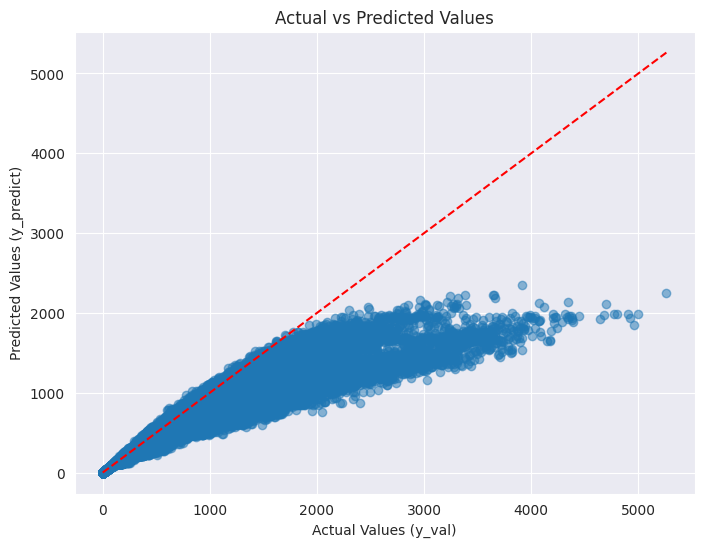

In [ ]:
# Plot y_predict against y_val, also add a straight line

import matplotlib.pyplot as plt

# Assuming y_predict and y_val are already calculated
plt.figure(figsize=(8, 6))
plt.scatter(y_val, model.predict(X_val), alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--') # Straight line
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_predict)')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

# Before transformation of y

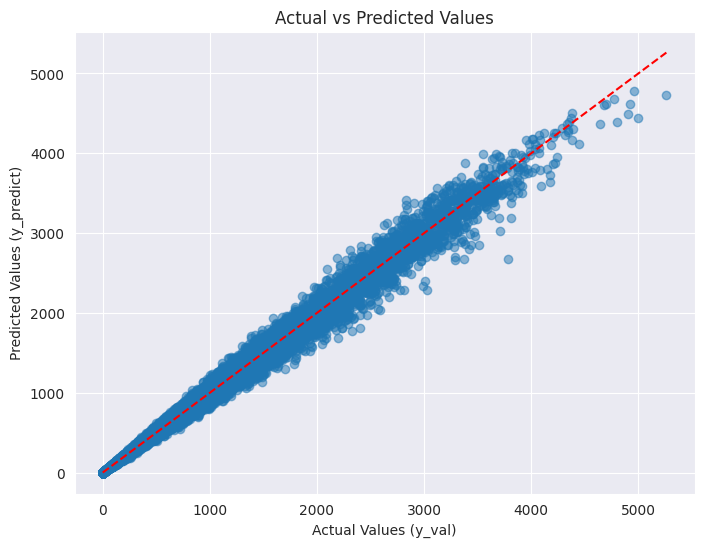

In [ ]:
# Plot y_predict against y_val, also add a straight line

import matplotlib.pyplot as plt

# Assuming y_predict and y_val are already calculated
plt.figure(figsize=(8, 6))
plt.scatter(np.exp(y_val), np.exp(model.predict(X_val)), alpha=0.5)
plt.plot([min(np.exp(y_val)), max(np.exp(y_val))], [min(np.exp(y_val)), max(np.exp(y_val))], color='red', linestyle='--') # Straight line
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_predict)')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

# # After transformation of y to y_log

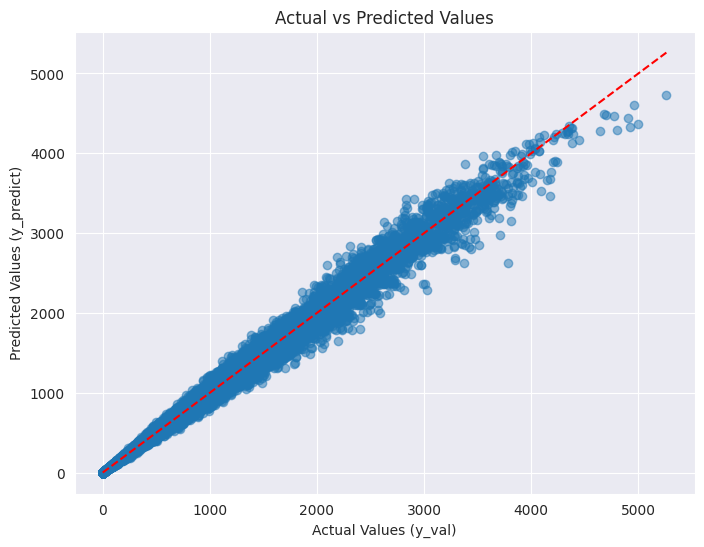

In [ ]:
# Plot y_predict against y_val, also add a straight line

import matplotlib.pyplot as plt

# Assuming y_predict and y_val are already calculated
plt.figure(figsize=(8, 6))
plt.scatter(np.exp(y_val), np.exp(model.predict(X_val)), alpha=0.5)
plt.plot([min(np.exp(y_val)), max(np.exp(y_val))], [min(np.exp(y_val)), max(np.exp(y_val))], color='red', linestyle='--') # Straight line
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_predict)')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

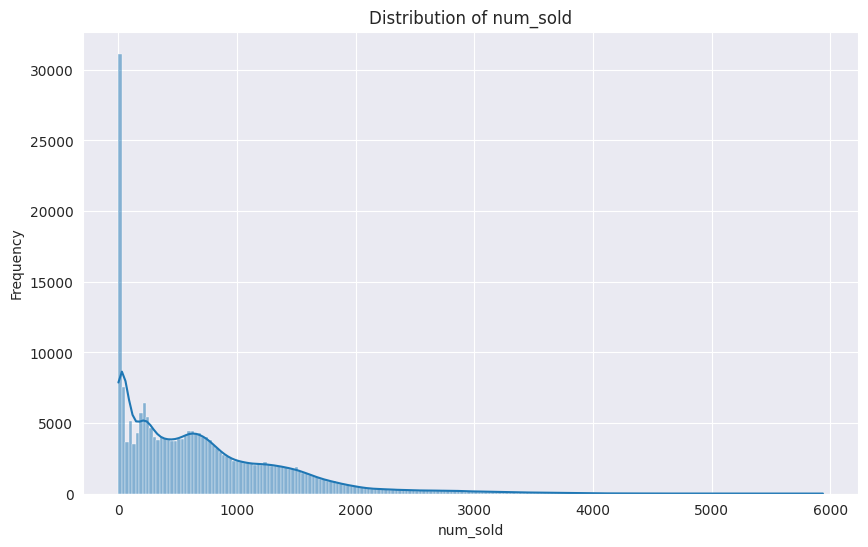

In [ ]:
# Plot distribution of num_sold in train_df_new

plt.figure(figsize=(10, 6))
sns.histplot((train_df_new['num_sold']), kde=True)
plt.title('Distribution of num_sold')
plt.xlabel('num_sold')
plt.ylabel('Frequency')
plt.show()

# Distribution of target num_sold is very right skewed

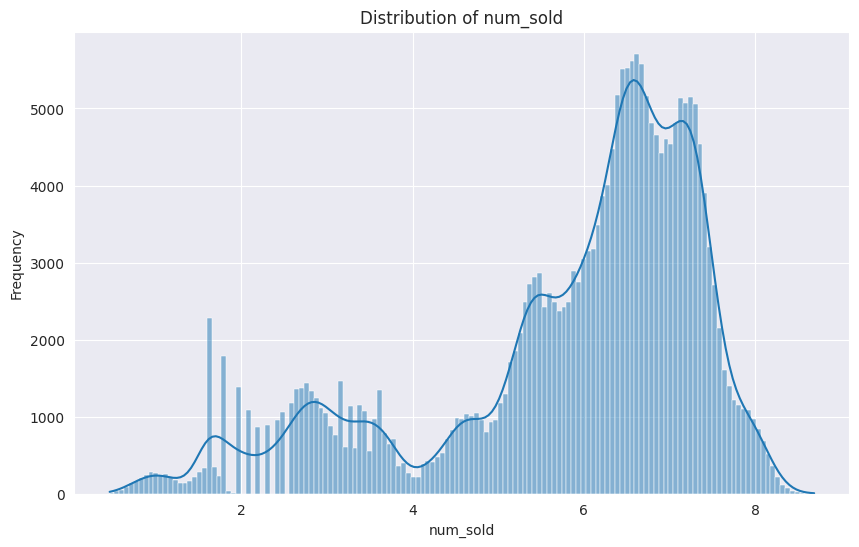

In [ ]:
# prompt: Plot distribution of num_sold in train_df_new

plt.figure(figsize=(10, 6))
sns.histplot(np.log(train_df_new['num_sold']), kde=True)
plt.title('Distribution of num_sold')
plt.xlabel('num_sold')
plt.ylabel('Frequency')
plt.show()

# After transforming the target num_sold, the distribution is less skewed
# Apply a transformation (e.g., log transformation) to normalize the target and reduce the impact of extreme values:

In [ ]:
# Make predictions on the test set

for col in categorical_features:
    test_df_new[col] = test_df_new[col].astype(str)

X_test = test_df_new.drop(['id', 'date'], axis=1)
# predictions = model.predict(X_test)
predictions = np.exp(model.predict(X_test))
predictions

array([ 142.19834968,  911.0509288 ,  783.80488092, ..., 1996.52011004,
       1110.98484216, 1320.43061299])

In [ ]:
# Create submission dataframe (assuming 'id' column is in test_df_new)
submission_df = pd.DataFrame({'num_sold': predictions})
submission_df.index = test_df_new['id']
submission_df

num_sold
id                 
230130   142.198350
230131   911.050929
230132   783.804881
230133   404.803892
230134   484.740475
...             ...
328675   387.887079
328676  2449.757182
328677  1996.520110
328678  1110.984842
328679  1320.430613

[98550 rows x 1 columns]

In [ ]:
submission_df.to_csv('catboost_new_3.csv', index=True)

# Submission score
# 0.10393

In [ ]:
# Make predictions on the test set

for col in categorical_features:
    test_df_new[col] = test_df_new[col].astype(str)

X_test = test_df_new.drop(['id', 'date'], axis=1)
# predictions = model.predict(X_test)
predictions = np.exp(model.predict(X_test))
predictions

array([ 146.38514481,  917.64843525,  783.42438917, ..., 2337.78879433,
       1344.48523844, 1531.8154823 ])

In [ ]:
# Create submission dataframe (assuming 'id' column is in test_df_new)
submission_df = pd.DataFrame({'num_sold': predictions})
submission_df.index = test_df_new['id']
submission_df

num_sold
id                 
230130   146.385145
230131   917.648435
230132   783.424389
230133   420.273077
230134   493.637454
...             ...
328675   478.344017
328676  2821.016748
328677  2337.788794
328678  1344.485238
328679  1531.815482

[98550 rows x 1 columns]

In [ ]:
# Save predictions to csv
submission_df.to_csv('catboost_new_2.csv', index=True)

# Submission score
# Using y: 0.16985
# Using np.log(y): 0.10440

# End